# Competition

# Strategy

In this competition I wanted to try to use only experience to predict the score of children. Experience in the sense of computer games like e.g. in The Bindings of Isaac, where for the first time you play, you loose almost immediately and it takes a lot of iterations to advance to the next level and finally win the game. In the same sense, children here spend time watching videos, playing sandbox games or minigames and earn experience about height, length, volume and weight. 

## Features

### Activity time

At first, I noticed that `game_time` is not really an useful feature. It is the timedelta from the last event or the time since the start of a game session. However, there is no ending event for the game session, so if you do not compute it yourself, you will not know how much time a kid actually spend doing the activity. 

So I took videos first. I watched every video in the game and noted down how long it is. Later, when I already had these information, hosts provided length of each video, but nevermind... Videos are the most affected by `game_time` as they have only starting event with `game_time = 0`. The only problem here is that if you add up whole video time everytime you could just count event, but I coped with this with video checkpoints mentioned later and also if I would only count video events, I wouldn't know the total time spend watching videos.

For other activities I did it differently, because there are a lot of events and time between them is short. However, it may happen that a kid does not turn of the game and the time keeps ticking. I have seen this in many kernels, that they just summed up the time and then they count with this time as with time spend in a game. The easiest thing to do is to set up a threshold, i.e. maximum time between events is 10 minutes. When I did this I still found these times too high, so I made a statistics for all events for every activity (except videos) and looked at the distribution of times between events. It was different for every activity, but based on these histograms I clipped maximum times somewhere between 7 and 16 seconds.

### Video checkpoints

When I watched the videos, I realized that useful infomation are said only sometimes in the video, e.g. there may be a song, then someone says something informative, then the song continues. I watched videos again and marked times where an information was said. These became checkpoints for a video and I counted the number of times a children crossed a checkpoint.

### Events

With events I went through all of them and tried to use really only the ones that show how a player is experienced. There are events like "click on the game in the main menu", "click somewhere where is no thing to click on" etc. I think there may be some value by computing how many times a kid misses everything, but it seemed like low-importance feaure. So instead, I computed maximum round, how many rounds were played, how many levels, I computed MAE and MSE for things like putting a dinosaur to a house (sizes of dinosaurs and houses 1, 2, 3) so that I would know how big are mistakes kids usually make, I computed ratios of correct vs. incorrect etc.

## Data processing

The data we are given are one row per each event. There are multiple events in a single game session. Every child (`installation_id`) plays multiple games (have multiple different `game_session` IDs). As we are supposed only for assessments, game sessions needs to be filtered in the end, so that we have a single row for a single assessment.

So I have functions which process the data grouped into three groups:
1. Funtions modifying full DataFrame
2. Functions aggregating full DataFrame and returning data in IID-GID DataFrame (IID = `installation_id`, GID = `game_session`)
3. Functions modifying aggregated DataFrame

In the first group there are functions like computing the actual time between events etc. The first function in the second group is `get_aggregated_base`, where I just get a skeleton of DataFrame with all IIDs and GIDs. I run functions from the second group and merge them with the base. In the third group I e.g. select samples based on whether they are for training or for testing.

Data processing in this competition needed to be done in chunks. It is not possible to load full data and work with them. Even if you somehow managed to, you wouldn't have enough memory for a model. But with functions divided in three groups like this, it was no problem. I just have to create a custom loading, so that installation IDs are not divided between chunks.

People soon realized here, that they do not have to use only the last assessment for training, but they can use all assessments for training. It is called *Truncated CV* here. I figured out that we can also use all assessments even from the training set (except the last ones we are supposed to predict of course), so I used them. There is not many additional assessments in the public test set, but there is certainly more of them in the private test set. It is blind shot, but as there are only 21K samples to train on, I thought that any additional sample is worth using.

## Predictions

### Cross validation

This brings us to the cross validation. If I wanted to use even test data I had to ensure that an `installation_id` from the test set is not used later for prediction of the same `installation_id`. So I used 2D-Shuffled-Grouped-K-Fold validation, grouped by `installation_id`. How does it work is shown on the following image:

From the train set, one fold is used for validation, all other folds are used for the training. From the test set I pick one fold and select its to-be-predicted samples - this fold is being predicted. From all other test folds I select training samples and they join training samples from the train set. On the figure there is 4x4 (4 train folds, 4 test folds) CV, so all models need to be trained on 16 different groups. In the end I used 5x6 so that the validation fold is not small and the model does not overfit due to low number of validation samples. I average solutions (using median for classification models and mean for regression models). This cross 4x4 validation is then repeated 3 times (bottom left corner) and I again average solutions (in the end everytime with median).

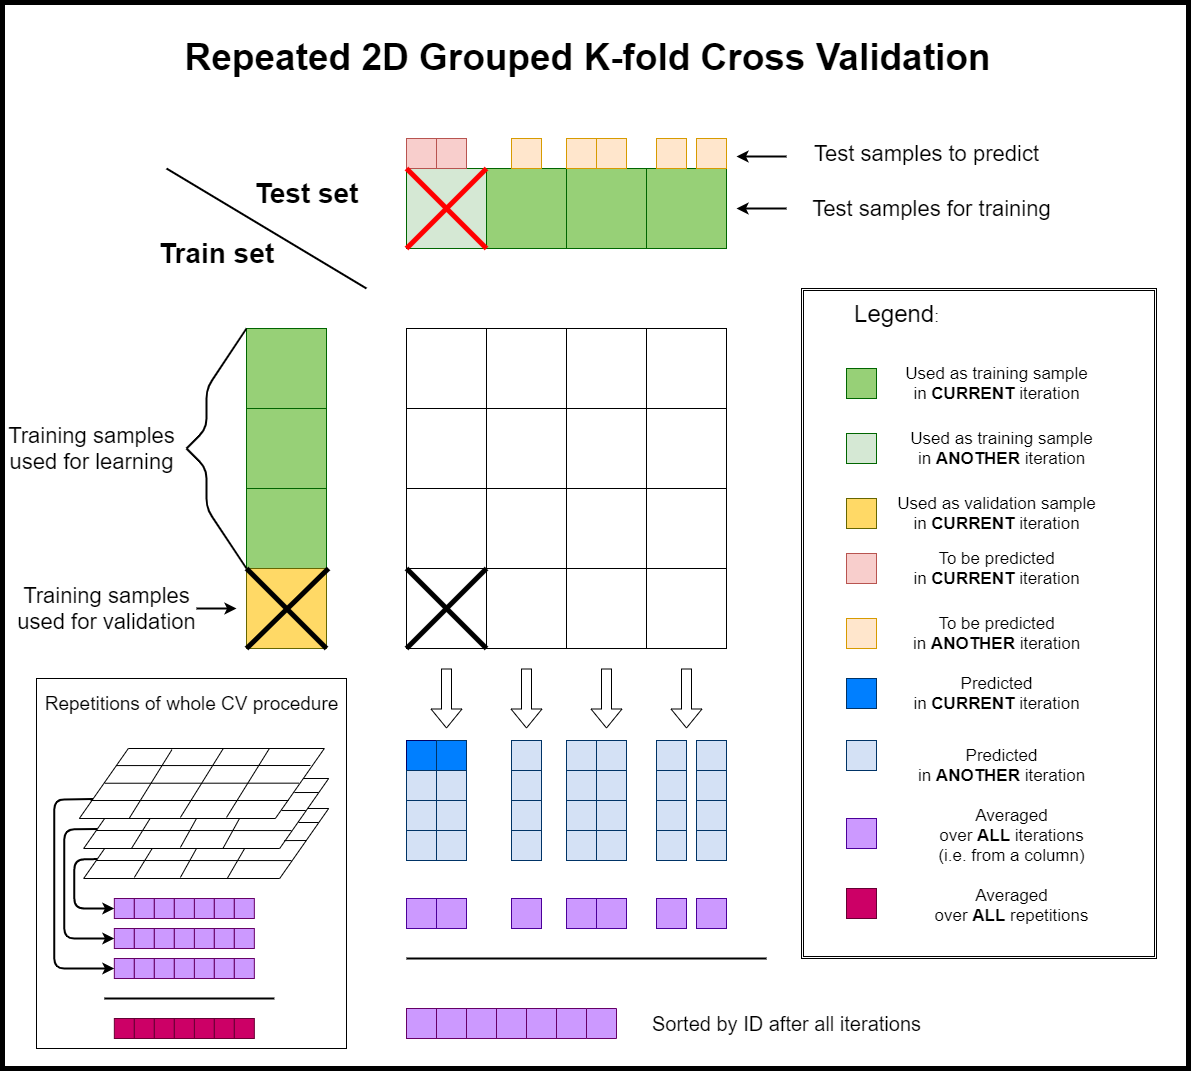

### Models

At first I started with a neural network and used all data without event data (because I didn't have them yet). It did not work well, so I switched to LightGBM which worked better. After I engineered the event data, I tried again neural network and it worked even better than LightGBM. 

In the end I ended using four models, one with two outputs, so in total with five outputs. During CV, all four models were trained on same samples and did validation on same samples as well, so out of every repetition I got not one, but five outputs and I used median to reduce them to a single prediction.

Models were:
- LightGBM with highest public LB (0.525), not shallow but not deep
- LightGBM regularized as much as it made sense (public LB 0.505)
- Basic feedforward NN with all features standardly scaled as input (highest public LB 0.535, but that was just luck, average is much lower)
- Complex NN with data divided by World and type of data (time, event, cumulative assessment data) with basic feedforward NN as head and two outputs - regression and ordinal classification (I think best LB was 0.496)

### Ordinal learning

In this competition people started to tackle this problem as classification. However, then it was shown that regression works better, so I guess most of the people switched to regression (including me). I also tried to find whether this problem has a name and it is apparently called ordinal learning or ordinal regression, i.e. predicted number are integer and they are ordered. I found out that one of basic tricks how to solve it is not to predict a category of a sample, but if a sample is at least in a category. So to belong to the category 2 (in this competition categories are 0, 1, 2 and 3) it has to predict 110, other examples in the figure below.

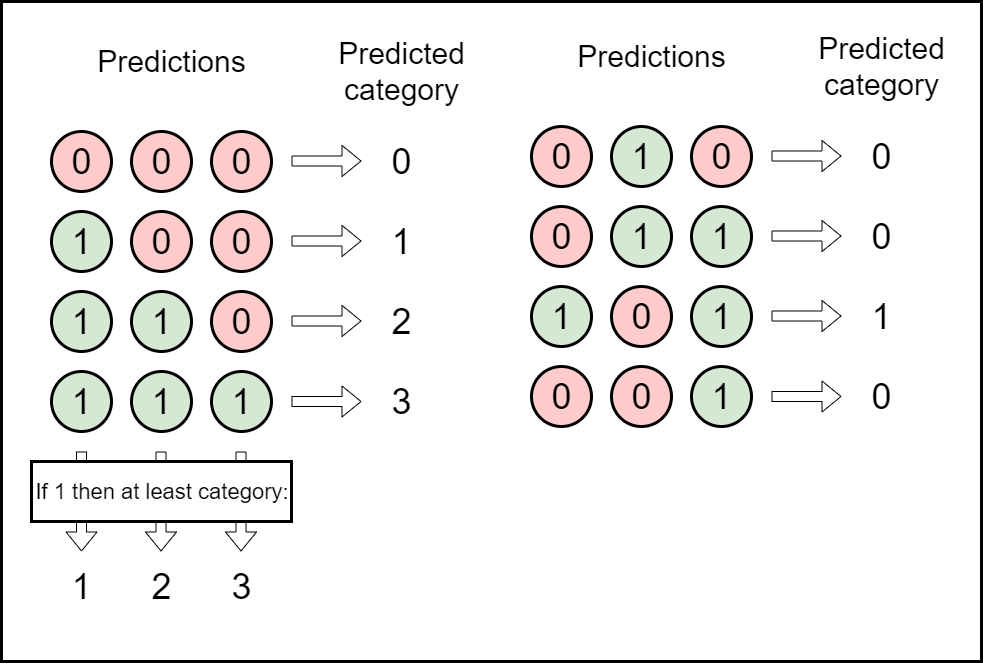

# Results

It turns out that this notebook did not work very well (1277.  place) . Maybe I made an error somewhere, so if you find out, let me know, please. People from top used very similar features and similar models, so I don't really know why it did not work for me. 

# Imports and settings

In [ ]:
# Standard library
import copy
import random
import gc
import json

# Specific imports from the standard library
from functools import partial

# Basic imports
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import scipy

# Graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm

# Keras
import keras
import keras.backend as K
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers
from tensorflow.python.ops import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import Callback

# Other things just to try
from numba import jit 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix as scikit_confusion_matrix

# Functions

In [ ]:
# I just needed to be sure, that this is really read in case there is an error
sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')

In [ ]:
# Funtions modifying full DataFrame

def get_useful_train_samples(df):
    """
    Get only installation ids which did at least one assessment.
    
    Without an assessment an installation id is useless as we can not use it for training.
    """
    usefull_installation_ids = list(df.loc[df["type"]=="Assessment", "installation_id"].unique())
    df = df.loc[df["installation_id"].isin(usefull_installation_ids), :]
    df = df.sort_values(by=["installation_id", "timestamp"])
    return df

def add_time_of_learning(df):
    """
    Get better estimation of time spend on every action.
    """
    df["game_time"] = df["game_time"] / 1000   # Convert game time to seconds
    df["timestamp"] = pd.to_datetime(df["timestamp"])   # Convert timestamp to datetime
    df = df.sort_values(by=["installation_id", "timestamp"])
    # Compute time of action, i.e. time spent on current action OR time until next action
    # Note that when IID changes we are subtracting values for different IIDs
    # and for last action there is no reasonable time, but we fix this later and set it to zero
    df["action_time"] = (df["timestamp"].shift(-1) - df["timestamp"])
    # Get positions of indices, i.e. where a group for IID starts/ends, where a group for IID and GID starts/ends
    first_I_indices = df.reset_index().groupby("installation_id")["index"].first().values
    last_I_indices = df.reset_index().groupby("installation_id")["index"].last().values
    first_IG_indices = df.reset_index().groupby(["installation_id", "game_session"])["index"].first().values
    last_IG_indices = df.reset_index().groupby(["installation_id", "game_session"])["index"].last().values
    # For last action there is no time until next action, so set it to zero.
    df.loc[df.index.isin(last_I_indices), "action_time"] = pd.Timedelta(0)
    # If timedelta is higher than X hours, then a child probably kept the game running but went away, do not count this time
    df.loc[df["action_time"] > pd.Timedelta(hours=3), "action_time"] = pd.Timedelta(0)
    df["action_time"] = df["action_time"].dt.total_seconds()   # Convert timedelta to seconds
    # Now time for everything is clipped at X time units, but for clips it is easy to get their max time.
    # So, watch all videos, time them and store those times.
    # For other things, you need to create histogram of times between actions and clip them
    # where you think it makes sense
    max_clip_times = {"Tree Top City - Level 1":15, "Ordering Spheres":60, "Costume Box":60, "12 Monkeys":110, "Tree Top City - Level 2":22,
                      "Pirate's Tale":80, "Treasure Map":155, "Tree Top City - Level 3":24, "Rulers":125,
                      "Crystal Caves - Level 1":16, "Balancing Act":70, "Crystal Caves - Level 2":22, "Crystal Caves - Level 3":17,
                      "Lifting Heavy Things":115, "Honey Cake":140, "Heavy, Heavier, Heaviest":53, 
                      "Magma Peak - Level 1":18, "Magma Peak - Level 2":20, "Slop Problem":55,
                     }
    max_game_times = {"Scrub-A-Dub":6.5, "All Star Sorting":5.1, "Air Show":7.3, "Dino Drink":6.9, 
                      "Bubble Bath":12.8, "Dino Dive":9.9, "Chow Time":12.2, "Pan Balance":7.7,
                      "Happy Camel":9.0, "Leaf Leader":8.9, "Crystals Rule":4.5}
    max_activity_times = {"Sandcastle Builder (Activity)":12.2, "Fireworks (Activity)":8.4, "Flower Waterer (Activity)":10.3,
                          "Bug Measurer (Activity)":5.8, "Watering Hole (Activity)":12.2, "Bottle Filler (Activity)":11.2,
                          "Chicken Balancer (Activity)":7.8, "Egg Dropper (Activity)":11.2}
    max_assessment_times = {"Mushroom Sorter (Assessment)":7.8, "Bird Measurer (Assessment)":7.6,
                            "Cauldron Filler (Assessment)":8.4, "Cart Balancer (Assessment)":8.4,
                            "Chest Sorter (Assessment)":10}    
    max_times = {**max_clip_times, **max_game_times, **max_activity_times, **max_assessment_times}
    # Now clip everything at its max timelength.
    for title, max_time in max_times.items():
        df.loc[df["title"]==title, "action_time"] = df.loc[df["title"]==title, "action_time"].clip(upper=max_time)  
    return df

def distinguish_train_and_test_asessments(dataframe):
    """
    Test data has event_count == 1 and event_code == 2000,
    other assessment should probably have more event counts
    
    New columns
    ===========
    is_train - True if it is training assessment,
        False if it is test assessment,
        None if it is not an assessment
    """
    agg_df = dataframe.loc[dataframe["type"]=="Assessment"].sort_values(by="timestamp")\
                      .groupby(by=["installation_id", "game_session"])\
                      .agg(N_events=("game_session", "count"),
                           sum_event_codes=("event_code", "sum")).reset_index()
    mask = (agg_df["N_events"] == 1) & (agg_df["sum_event_codes"] == 2000)
    test_game_ids = agg_df.loc[mask, "game_session"].to_list()
    dataframe.loc[dataframe["type"]=="Assessment", "is_train"] = True
    dataframe.loc[dataframe["game_session"].isin(test_game_ids), "is_train"] = False
    return dataframe

def one_hot_assessments(df):
    one_hot = pd.get_dummies(df.loc[df["type"]=="Assessment", "title"]).add_prefix("OH - ")
    df = pd.merge(df, one_hot, how="left", left_index=True, right_index=True)
    return df

def label_encode_assessments(df):
    label_dict = {"Chest Sorter (Assessment)":[0, 0], "Bird Measurer (Assessment)":[1, 1],
                  "Mushroom Sorter (Assessment)":[2, 1], "Cauldron Filler (Assessment)":[3, 0],
                  "Cart Balancer (Assessment)":[4, 2]}
    for name, labels in label_dict.items():
        df.loc[df["title"]==name, "AssessmentLabel"] = labels[0]
        df.loc[df["title"]==name, "WorldLabel"] = labels[1]
    return df

def fix_event_data(df):
    df.loc[:, "event_data"] = df["event_data"].apply(json.loads)
    return df

In [ ]:
# Helper functions for event aggregations

def get_hole_size(row):
    """
    Helper function for find_dino_drinks.
    """
    return row["holes"][row["hole_position"]-1]["size"]

def get_measurement_type(row):
    """
    Helper function for find_camel_bowls.
    """
    if row["TotalCamelBowls"] == 2:
        if row["BowlsFromResources"] == 2:
            return "Good"
        else:
            return "Bad"
    elif row["TotalCamelBowls"] == 3:
        if row["BowlsFromResources"] == 2:
            if row["ToyMeasuredNTimes"] == 0:
                return "Great"
        if row["ToyMeasuredNTimes"] == 1:
            return "Good"
        else:
            return "Bad"        
    elif row["TotalCamelBowls"] == 4:
        if row["BowlsFromResources"] == 2:
            if row["ToyMeasuredNTimes"] == 1:
                return "Good"
            else:
                return "Bad"
        if row["BowlsFromResources"] == 3:
            if row["ToyMeasuredNTimes"] == 0:
                return "Great"
        if row["ToyMeasuredNTimes"] == 1:
            return "Good"
        else:
            return "Bad"
        

In [ ]:
# IID = installation ID
# GID = game session ID

# Functions aggregating full DataFrame and returning data in IID-GID DataFrame

def get_aggregated_base(df):
    return df.sort_values(by=["installation_id", "timestamp"]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")

def get_time_spent_on_actions(dataframe):
    df = dataframe[["installation_id", "game_session", "title", "type", "world", "timestamp"]].drop_duplicates()
    df = df.sort_values(by=["installation_id", "timestamp"])
    time_spent_on_actions = dataframe.sort_values(by=["installation_id", "timestamp"]).groupby(["installation_id", "game_session"]).agg(single_activity_time=('action_time', sum)).reset_index()
    df = pd.merge(df, time_spent_on_actions, how="left",
                    left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df.drop_duplicates(subset=["installation_id", "game_session", "title", "timestamp"])
    df = df.pivot_table(index=["installation_id", "game_session", "timestamp"], columns="title", values="single_activity_time").fillna(0).reset_index()
    df = df.sort_values(by=["installation_id", "timestamp"]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")
    cols_for_cumsum = list(df.columns)
    cols_for_cumsum.remove('installation_id')
    cols_for_cumsum.remove('game_session')
    cols_for_cumsum.remove('timestamp')
    for col in cols_for_cumsum:
        df.loc[:, col] = df.groupby(["installation_id"])[col].cumsum()
    renaming = {}
    for col in cols_for_cumsum:
        renaming[col] = f"total_time_on-{col}"
    df = df.rename(renaming, axis=1)
    df = df.drop("timestamp", axis=1)
    return df

def get_views_of_clip_checkpoints(dataframe):
    df = dataframe[["installation_id", "game_session", "title", "type", "world", "timestamp"]].drop_duplicates()
    df = df.sort_values(by=["installation_id", "timestamp"])
    time_spent_on_actions = dataframe.sort_values(by=["installation_id", "timestamp"]).groupby(["installation_id", "game_session"]).agg(single_activity_time=('action_time', sum)).reset_index()
    df = pd.merge(df, time_spent_on_actions, how="left",
                    left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df.drop_duplicates(subset=["installation_id", "game_session", "title"])
    df = df.pivot_table(index=["installation_id", "game_session", "timestamp"], columns="title", values="single_activity_time").fillna(0).reset_index()
    df = df.sort_values(by=["installation_id", "timestamp"]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")
    useful_clip_times = {"Ordering Spheres":[29, 37], "Costume Box":[16, 27], "12 Monkeys":[17, 70], 
                         "Tree Top City - Level 2":[16], "Pirate's Tale":[30, 38, 60], "Treasure Map":[15, 39, 105], 
                         "Tree Top City - Level 3":[17], "Rulers":[39, 95],
                         "Balancing Act":[30, 50], "Crystal Caves - Level 2":[8, 12, 18], 
                         "Crystal Caves - Level 3":[12],
                         "Lifting Heavy Things":[35, 55, 85, 105], "Honey Cake":[80, 130], "Heavy, Heavier, Heaviest":[37], 
                         "Magma Peak - Level 2":[15], "Slop Problem":[15, 27, 44],
                         }
    list_of_needed_columns = ["installation_id", "game_session"]
    for clip, list_of_checkpoints in useful_clip_times.items():
        for checkpoint_number, checkpoint_value in enumerate(list_of_checkpoints):
            column_name = f"{clip}-Checkpoint_{checkpoint_number+1}"
            df[column_name] = df[f"{clip}"] >= checkpoint_value
            df.loc[:, column_name] = df.groupby(["installation_id"])[column_name].cumsum()
            list_of_needed_columns.append(column_name)
    df = df.loc[:, list_of_needed_columns]
    return df

def get_assessment_info(df):
    """
    Get info about assessments, how many times children tried to finish the assessment and how many times did they answered in/correctly.
    
    Every assessment has its own end code, so we can filter using these event end codes.
    Using event data we find whether the answer was in/correct.
    
    Returns
    -------
    Dataframe with installation_id, game_session, number of in/correct tries and how many times the assessment was ran.
    """
    assessment_end_codes = {"Bird Measurer (Assessment)":4110, "Cart Balancer (Assessment)":4100,
                            "Cauldron Filler (Assessment)":4100, "Chest Sorter (Assessment)":4100,
                            "Mushroom Sorter (Assessment)":4100}
    a = copy.deepcopy(df[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    for assessment_name, end_code in assessment_end_codes.items():
        basic_mask = (df["title"] == assessment_name) & (df["event_code"]==end_code)
        c = df.loc[basic_mask, :].sort_values(by=["installation_id", "timestamp"])
        incorrect_mask = (c["event_data"].str.contains('"correct":false'))
        c.loc[incorrect_mask, f"{assessment_name}-CumIncorrectNumber"] = c.loc[incorrect_mask, :].groupby(["installation_id"])["title"].cumcount() + 1
        correct_mask = (c["event_data"].str.contains('"correct":true'))
        c.loc[correct_mask, f"{assessment_name}-CumCorrectNumber"] = c.loc[correct_mask, :].groupby(["installation_id"])["title"].cumcount() + 1
        cols = [f"{assessment_name}-CumIncorrectNumber", f"{assessment_name}-CumCorrectNumber"]
        b = c.sort_values(by=["installation_id", "game_session", "timestamp"]).drop_duplicates(["installation_id"], keep="first")
        b = b.fillna(0)
        c = c.combine_first(b)
        c[cols] = c[cols].fillna(method='ffill')
        c[cols] = c[cols].fillna(0)
        c[cols] = c[cols].astype(int)    
        q = copy.deepcopy(c)
        d = c.groupby(["installation_id", "game_session"]).agg(N_correct_number=(f"{assessment_name}-CumCorrectNumber", "max"), 
                                                           N_incorrect_number=(f"{assessment_name}-CumIncorrectNumber", "max")).reset_index()
        g = copy.deepcopy(c.loc[:, ["installation_id", "game_session"]].drop_duplicates(keep="first"))
        g[f"{assessment_name}-N_assessment"] = g.groupby(["installation_id"]).cumcount() + 1  
        d = d.rename({"N_correct_number":f"{assessment_name}-N_correct_tries", "N_incorrect_number":f"{assessment_name}-N_incorrect_tries"}, axis=1)#, "N_assessment":f"{assessment_name}-N_assessment"}, axis=1)
        a = pd.merge(a, d, how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
        a = pd.merge(a, g, how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    q = copy.deepcopy(g)
    cols = list(a.columns)
    cols.remove("installation_id")
    cols.remove("game_session")
    e = a.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    f = a.combine_first(e)
    f[cols] = f[cols].fillna(method='ffill')
    f[cols] = f[cols].astype(int)
    return f

def compute_accuracy_group(df):
    """
    Accuracy group can be computed only for train assessments.
    """
    assessment_end_codes = {"Bird Measurer (Assessment)":4110, "Cart Balancer (Assessment)":4100,
                            "Cauldron Filler (Assessment)":4100, "Chest Sorter (Assessment)":4100,
                            "Mushroom Sorter (Assessment)":4100}
    a = copy.deepcopy(df[["installation_id", "game_session", "type"]]).drop_duplicates(subset=["installation_id", "game_session", "type"])
    a["accuracy_group"] = np.NaN
    for assessment_name, end_code in assessment_end_codes.items():
        basic_mask = (df["title"] == assessment_name) & (df["event_code"]==end_code)
        c = df.loc[basic_mask, :].sort_values(by=["installation_id", "timestamp"])
        incorrect_mask = (c["event_data"].str.contains('"correct":false'))
        c.loc[incorrect_mask, f"{assessment_name}-IncorrectNumber"] = c.loc[incorrect_mask, :].groupby(["installation_id", "game_session"])["title"].cumcount() + 1
        correct_mask = (c["event_data"].str.contains('"correct":true'))
        c.loc[correct_mask, f"{assessment_name}-CorrectNumber"] = c.loc[correct_mask, :].groupby(["installation_id", "game_session"])["title"].cumcount() + 1
        cols = [f"{assessment_name}-IncorrectNumber", f"{assessment_name}-CorrectNumber"]
        b = c.sort_values(by=["installation_id", "game_session", "timestamp"]).drop_duplicates(["installation_id", "game_session"], keep="first")
        b = b.fillna(0)
        c = c.combine_first(b)
        c[cols] = c[cols].fillna(method='ffill')
        c[cols] = c[cols].fillna(0)
        c[cols] = c[cols].astype(int)
        d = c.sort_values(by=["installation_id", "game_session", "timestamp"]).drop_duplicates(subset=["installation_id", "game_session"], keep="last")
        d["new_accuracy_group"] = 0
        d.loc[(d[f"{assessment_name}-CorrectNumber"]==1) & (d[f"{assessment_name}-IncorrectNumber"]==0), "new_accuracy_group"] = 3
        d.loc[(d[f"{assessment_name}-CorrectNumber"]==1) & (d[f"{assessment_name}-IncorrectNumber"]==1), "new_accuracy_group"] = 2
        d.loc[(d[f"{assessment_name}-CorrectNumber"]==1) & (d[f"{assessment_name}-IncorrectNumber"]>1), "new_accuracy_group"] = 1
        d = d.loc[:, ["installation_id", "game_session", "new_accuracy_group"]]
        a = pd.merge(a, d, how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
        a["accuracy_group"] = a["accuracy_group"].combine_first(a["new_accuracy_group"])
        a = a.drop(["new_accuracy_group"], axis=1)
    a.loc[a["type"]=="Assessment", "accuracy_group"] = a.loc[a["type"]=="Assessment", "accuracy_group"].fillna(0)
    a = a.drop(["type"], axis=1)
    return a

def compute_assessment_streak(dataframe):
    """
    It is certainly very important to know how many successive
    tries were in/correct. Because if a child likes this assessment
    and finished it correctly multiple times in a row, it will
    certainly finish it correctly even for the next try.
    """
    pass

def find_sandcastles_built(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="84538528"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    sizes = json_normalize(df["event_data"], max_level=0)[["size"]]
    df["SandcastleSizes"] = sizes["size"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "SandcastleSizes"]]
    df = pd.concat((df,pd.get_dummies(df["SandcastleSizes"]).add_prefix("SandcastleOfHeight-")), axis=1) 
    g = df.groupby(by="installation_id").agg(TotalHeightOfSandcastles=("SandcastleSizes", "cumsum"),
                                         SandcastlesBuilt=("SandcastleSizes", "cumcount"),
                                         SmallSandcastlesBuilt=("SandcastleOfHeight-1", "cumsum"),
                                         MediumSandcastlesBuilt=("SandcastleOfHeight-2", "cumsum"),
                                         BigSandcastlesBuilt=("SandcastleOfHeight-3", "cumsum"))
    cols = ["TotalHeightOfSandcastles", "SandcastlesBuilt", "SmallSandcastlesBuilt", "MediumSandcastlesBuilt", "BigSandcastlesBuilt"]
    g["SandcastlesBuilt"] = g["SandcastlesBuilt"] + 1
    g["installation_id"] = df["installation_id"]
    g["game_session"] = df["game_session"]
    a = g.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_clouds_rained(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="2fb91ec1"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    sizes = json_normalize(df["event_data"], max_level=0)[["cloud_size"]]
    df["CloudSizes"] = sizes["cloud_size"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "CloudSizes"]]
    df = pd.concat((df,pd.get_dummies(df["CloudSizes"]).add_prefix("CloudOdSize-")), axis=1) 
    g = df.groupby(by="installation_id").agg(
                                         CloudsRained=("CloudSizes", "cumcount"),
                                         SmallCloudSizes=("CloudOdSize-1", "cumsum"),
                                         MediumCloudSizes=("CloudOdSize-2", "cumsum"),
                                         BigCloudSizes=("CloudOdSize-3", "cumsum"))
    cols = ["CloudsRained", "SmallCloudSizes", "MediumCloudSizes", "BigCloudSizes"]
    g["CloudsRained"] = g["CloudsRained"] + 1
    g["installation_id"] = df["installation_id"]
    g["game_session"] = df["game_session"]
    a = g.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_fireworks_launched(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="e694a35b"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["FireworksLaunched"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["FireworksLaunched"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_flowers_collected(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="fcfdffb6"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["FlowersCollected"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["FlowersCollected"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_bottles_filled(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="e9c52111"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["BottlesFilled"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["BottlesFilled"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_eggs_dropped(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="4c2ec19f"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["EggsDropped"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["EggsDropped"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_dinoscale_changes(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="461eace6"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["DinoScaleChanges"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["DinoScaleChanges"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_bugs_measured(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="022b4259"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    sizes = json_normalize(df["event_data"], max_level=0)[["buglength"]]
    df["MeasuredBuglength"] = sizes["buglength"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "MeasuredBuglength"]]
    g = df.groupby(by="installation_id").agg(TotalBuglengthMeasured=("MeasuredBuglength", "cumsum"),
                                         TotalBugMeasurements=("MeasuredBuglength", "cumcount"),
                                         MaximumBuglengthMeasured=("MeasuredBuglength", "cummax"))
    cols = ["TotalBuglengthMeasured", "TotalBugMeasurements", "MaximumBuglengthMeasured"]
    g["TotalBugMeasurements"] = g["TotalBugMeasurements"] + 1
    g["installation_id"] = df["installation_id"]
    g["game_session"] = df["game_session"]
    a = g.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_bath_estimates(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="3bb91dda"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)[["containers", "correct", "target_containers"]]
    df["ContainersEstimate"] = estimate_info["containers"].values
    df["IsBathEstimateCorrect"] = estimate_info["correct"].values
    df["ContainersCorrectTarget"] = estimate_info["target_containers"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsBathEstimateCorrect"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "ContainersEstimate", "IsBathEstimateCorrect", "ContainersCorrectTarget"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsBathEstimateCorrect"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "ContainersEstimate", "IsBathEstimateCorrect", "ContainersCorrectTarget"]]
    g_correct = df_correct.groupby(by="installation_id").agg(PointsPerCorrectContainers=("ContainersCorrectTarget", "cumsum"),
                                                             MaximumCorrectNumberOfContainers=("ContainersCorrectTarget", "cummax"),
                                                             NCorrectlyEstimatedContainers=("ContainersCorrectTarget", "cumcount"))
    g_correct["NCorrectlyEstimatedContainers"] = g_correct["NCorrectlyEstimatedContainers"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(NIncorrectlyEstimatedContainers=("ContainersCorrectTarget", "cumcount"))
    g_incorrect["NIncorrectlyEstimatedContainers"] = g_incorrect["NIncorrectlyEstimatedContainers"] + 1
    cols = ["PointsPerCorrectContainers", "MaximumCorrectNumberOfContainers", "NCorrectlyEstimatedContainers", "NIncorrectlyEstimatedContainers"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalBathEstimates"] = (final["NCorrectlyEstimatedContainers"] + final["NIncorrectlyEstimatedContainers"]).astype(int)
    final["RatioOfCorrectBathEstimates"] = final["NCorrectlyEstimatedContainers"] / final["TotalBathEstimates"]
    final["RatioOfCorrectBathEstimates"] = final["RatioOfCorrectBathEstimates"].fillna(0)
    return final

def find_chickens_on_seesaw(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="499edb7c"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["ChickensOnSeesaw"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["ChickensOnSeesaw"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_pigs_on_seesaw(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="46cd75b4"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["PigsOnSeesaw"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["PigsOnSeesaw"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_correct_air_shows(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="9b4001e4"]
    base = copy.deepcopy(dataframe.sort_values(by=["installation_id", "timestamp"])[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session"]]
    df["CorrectAirShows"] = df.groupby(by="installation_id")["installation_id"].cumcount() + 1 
    cols = ["CorrectAirShows"]
    a = df.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    return final

def find_incorrect_air_shows(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="7423acbc"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    event_info = json_normalize(df["event_data"], max_level=0)[["identifier"]]
    df["ErrorType"] = event_info["identifier"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "ErrorType"]]
    df = pd.concat((df,pd.get_dummies(df["ErrorType"])), axis=1) 
    g = df.groupby(by="installation_id").agg(
                                         BadAirShowBetweenCliff=("WrongBetweenCliff", "cumsum"),
                                         BadAirShowBetweenTree=("WrongBetweenTree", "cumsum"),
                                         BadAirShowOver=("WrongOver", "cumsum"),
                                         BadAirShowUnder=("WrongUnder", "cumsum"))
    cols = ["BadAirShowBetweenCliff", "BadAirShowBetweenTree", "BadAirShowOver", "BadAirShowUnder"]
    g["installation_id"] = df["installation_id"]
    g["game_session"] = df["game_session"]
    a = g.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["IncorrectAirShows"] = (final["BadAirShowBetweenCliff"] + final["BadAirShowBetweenTree"] +
                                  final["BadAirShowOver"] + final["BadAirShowUnder"]).astype(int)
    return final

def find_crystal_rulers(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="86c924c4"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)[["correct", "round"]]
    df["IfCrystalSizeCorrect"] = estimate_info["correct"].values
    df["RoundNumber"] = estimate_info["round"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IfCrystalSizeCorrect"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IfCrystalSizeCorrect", "RoundNumber"]]
    df_incorrect = copy.deepcopy(df.loc[df["IfCrystalSizeCorrect"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IfCrystalSizeCorrect", "RoundNumber"]]
    g_correct = df_correct.groupby(by="installation_id").agg(MaxCrystalFinishedRound=("RoundNumber", "cummax"),
                                                             CrystalsMeasuredCorrectly=("RoundNumber", "cumcount"))
    g_correct["CrystalsMeasuredCorrectly"] = g_correct["CrystalsMeasuredCorrectly"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(CrystalsMeasuredIncorrectly=("RoundNumber", "cumcount"))
    g_incorrect["CrystalsMeasuredIncorrectly"] = g_incorrect["CrystalsMeasuredIncorrectly"] + 1
    cols = ["MaxCrystalFinishedRound", "CrystalsMeasuredCorrectly", "CrystalsMeasuredIncorrectly"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalCrystalMeasurements"] = (final["CrystalsMeasuredCorrectly"] + final["CrystalsMeasuredIncorrectly"]).astype(int)
    final["RatioOfCorrectCrystalMeasurements"] = final["CrystalsMeasuredCorrectly"] / final["TotalCrystalMeasurements"]
    final["RatioOfCorrectCrystalMeasurements"] = final["RatioOfCorrectCrystalMeasurements"].fillna(0)
    return final

def find_clean_animals(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="5c3d2b2f"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)[["size", "animal", "correct", "round", "level"]]
    animal_sizes = {"chicken":0, "sheep":1, "pig":2, "hog":3, "cow":4}
    estimate_info = estimate_info.replace({"animal": animal_sizes})
    df["IsSizeForAnimalCorrect"] = estimate_info["correct"].values
    df["RoundNumber"] = estimate_info["round"].values
    df["LevelNumber"] = estimate_info["level"].values
    df["AnimalSize"] = estimate_info["animal"].values
    df["SelectedSize"] = estimate_info["size"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsSizeForAnimalCorrect"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IsSizeForAnimalCorrect", "RoundNumber", "LevelNumber", "AnimalSize", "SelectedSize"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsSizeForAnimalCorrect"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IsSizeForAnimalCorrect", "RoundNumber", "LevelNumber", "AnimalSize", "SelectedSize"]]
    df_incorrect["AE"] = np.abs(df["AnimalSize"]-df["SelectedSize"])
    df_incorrect["SE"] = (df["AnimalSize"]-df["SelectedSize"])**2
    g_correct = df_correct.groupby(by="installation_id").agg(MaxScrubADubRound=("RoundNumber", "cummax"),
                                                             MaxScrubADubLevel=("LevelNumber", "cummax"),
                                                             CorrectScrubADubChoices=("SelectedSize", "cumcount"))
    g_correct["CorrectScrubADubChoices"] = g_correct["CorrectScrubADubChoices"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(IncorrectScrubADubChoices=("SelectedSize", "cumcount"),
                                                                 CumulativeAbsoluteScrubADubError=("AE", "cumsum"),
                                                                 CumulativeSquaredScrubADubError=("SE", "cumsum"))
    g_incorrect["IncorrectScrubADubChoices"] = g_incorrect["IncorrectScrubADubChoices"] + 1
    cols = ["MaxScrubADubRound", "MaxScrubADubLevel", "CorrectScrubADubChoices",
            "IncorrectScrubADubChoices", "CumulativeAbsoluteScrubADubError", "CumulativeSquaredScrubADubError"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalScrubADubChoices"] = (final["CorrectScrubADubChoices"] + final["IncorrectScrubADubChoices"]).astype(int)
    final["ScrubADubMAE"] = final["CumulativeAbsoluteScrubADubError"] / final["TotalScrubADubChoices"]
    final["ScrubADubMSE"] = final["CumulativeSquaredScrubADubError"] / final["TotalScrubADubChoices"]
    final["RatioOfCorrectScrubADubChoices"] = final["CorrectScrubADubChoices"] / final["TotalScrubADubChoices"]
    final["ScrubADubMAE"] = final["ScrubADubMAE"].fillna(4)
    final["ScrubADubMSE"] = final["ScrubADubMSE"].fillna(16)
    final["RatioOfCorrectScrubADubChoices"] = final["RatioOfCorrectScrubADubChoices"].fillna(0)
    return final

def find_dino_drinks(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="74e5f8a7"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)
    estimate_info["hole_size"] = estimate_info.apply(lambda row: get_hole_size(row), axis=1)
    estimate_info = estimate_info[["shell_size", "hole_size", "correct", "round"]]
    df["IsSizeOfDrinkCorrect"] = estimate_info["correct"].values
    df["RoundNumber"] = estimate_info["round"].values
    df["ShellSize"] = estimate_info["shell_size"].values
    df["DrinkSize"] = estimate_info["hole_size"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsSizeOfDrinkCorrect"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IsSizeOfDrinkCorrect", "RoundNumber", "ShellSize", "DrinkSize"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsSizeOfDrinkCorrect"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IsSizeOfDrinkCorrect", "RoundNumber", "ShellSize", "DrinkSize"]]
    df_incorrect["AE"] = np.abs(df["DrinkSize"]-df["ShellSize"])
    df_incorrect["SE"] = (df["DrinkSize"]-df["ShellSize"])**2
    df_incorrect["TooMuchError"] = df["ShellSize"] > df["DrinkSize"]
    df_incorrect["TooLittleError"] = df["ShellSize"] < df["DrinkSize"]
    g_correct = df_correct.groupby(by="installation_id").agg(MaxDinoDrinkRound=("RoundNumber", "cummax"),
                                                             CorrectDinoDrinks=("ShellSize", "cumcount"))
    g_correct["CorrectDinoDrinks"] = g_correct["CorrectDinoDrinks"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(IncorrectDinoDrinks=("ShellSize", "cumcount"),
                                                                 CumulativeAbsoluteDinoDrinkError=("AE", "cumsum"),
                                                                 CumulativeSquaredDinoDrinkError=("SE", "cumsum"),
                                                                 TooBigDinoDrinkErrors=("TooMuchError", "cumsum"),
                                                                 TooLittleDinoDrinkErrors=("TooLittleError", "cumsum"))
    g_incorrect["IncorrectDinoDrinks"] = g_incorrect["IncorrectDinoDrinks"] + 1
    cols = ["MaxDinoDrinkRound", "CorrectDinoDrinks", "IncorrectDinoDrinks",
            "CumulativeAbsoluteDinoDrinkError", "CumulativeSquaredDinoDrinkError",
            "TooBigDinoDrinkErrors", "TooLittleDinoDrinkErrors"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalDinoDrinks"] = (final["CorrectDinoDrinks"] + final["IncorrectDinoDrinks"]).astype(int)
    final["DinoDrinksMAE"] = final["CumulativeAbsoluteDinoDrinkError"] / final["TotalDinoDrinks"]
    final["DinoDrinksMSE"] = final["CumulativeSquaredDinoDrinkError"] / final["TotalDinoDrinks"]
    final["RatioOfCorrectDinoDrinks"] = final["CorrectDinoDrinks"] / final["TotalDinoDrinks"]
    final["DinoDrinksMAE"] = final["DinoDrinksMAE"].fillna(3)
    final["DinoDrinksMSE"] = final["DinoDrinksMSE"].fillna(9)
    final["RatioOfCorrectDinoDrinks"] = final["RatioOfCorrectDinoDrinks"].fillna(0)
    return final

def find_balanced_pans(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="a5e9da97"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)[["scale_weights", "target_weight", "correct", "round"]]
    df["IsPanBalanced"] = estimate_info["correct"].values
    df["RoundNumber"] = estimate_info["round"].values
    df["RockWeight"] = estimate_info["scale_weights"].values
    df["WeightsWeight"] = estimate_info["target_weight"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsPanBalanced"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IsPanBalanced", "RoundNumber", "RockWeight", "WeightsWeight"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsPanBalanced"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IsPanBalanced", "RoundNumber", "RockWeight", "WeightsWeight"]]
    df_incorrect["AE"] = np.abs(df["RockWeight"]-df["WeightsWeight"])
    df_incorrect["SE"] = (df["RockWeight"]-df["WeightsWeight"])**2
    g_correct = df_correct.groupby(by="installation_id").agg(MaxPanBalanceRound=("RoundNumber", "cummax"),
                                                             CorrectPanBalances=("WeightsWeight", "cumcount"))
    g_correct["CorrectPanBalances"] = g_correct["CorrectPanBalances"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(IncorrectPanBalances=("WeightsWeight", "cumcount"),
                                                                 CumulativeAbsolutePanBalanceError=("AE", "cumsum"),
                                                                 CumulativeSquaredPanBalanceError=("SE", "cumsum"))
    g_incorrect["IncorrectPanBalances"] = g_incorrect["IncorrectPanBalances"] + 1
    cols = ["MaxPanBalanceRound", "CorrectPanBalances", "IncorrectPanBalances",
            "CumulativeAbsolutePanBalanceError", "CumulativeSquaredPanBalanceError"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalPanBalances"] = (final["CorrectPanBalances"] + final["IncorrectPanBalances"]).astype(int)
    final["PanBalanceMAE"] = final["CumulativeAbsolutePanBalanceError"] / final["TotalPanBalances"]
    final["PanBalanceMSE"] = final["CumulativeSquaredPanBalanceError"] / final["TotalPanBalances"]
    final["RatioOfCorrectPanBalances"] = final["CorrectPanBalances"] / final["TotalPanBalances"]
    final["PanBalanceMAE"] = final["PanBalanceMAE"].fillna(5)
    final["PanBalanceMSE"] = final["PanBalanceMSE"].fillna(25)
    final["RatioOfCorrectPanBalances"] = final["RatioOfCorrectPanBalances"].fillna(0)
    return final

def find_camel_bowls(dataframe):
    df1 = dataframe.loc[dataframe["event_id"]=="c2baf0bd"]
    event_info = json_normalize(df1["event_data"], max_level=0)
    df1["TotalCamelBowls"] = event_info["total_bowls"].values
    df1["RoundNumber"] = event_info["round"].values
    base = copy.deepcopy(dataframe[["installation_id", "game_session", "timestamp"]]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")
    infobase = copy.deepcopy(base)
    infobase = pd.merge(infobase, df1[["installation_id", "game_session", "RoundNumber", "TotalCamelBowls"]], how="inner", on=["installation_id", "game_session"])
    df2 = dataframe.loc[dataframe["event_id"]=="8af75982"]
    event_info = json_normalize(df2["event_data"], max_level=0)
    df2["IsToyInBowl"] = event_info["correct"].values
    df2["IsToyInBowl"] = df2["IsToyInBowl"].astype(int)
    df2["RoundNumber"] = event_info["round"].values
    df2 = df2.groupby(by=["installation_id", "game_session", "RoundNumber"]).agg(CamelGuesses=("IsToyInBowl", "count"),
                                                                                 CorrectCamelGuesses=("IsToyInBowl", "sum")).reset_index()
    df2["IncorrectCamelGuesses"] = df2["CamelGuesses"] - df2["CorrectCamelGuesses"]
    infobase = pd.merge(infobase, df2, how="inner", on=["installation_id", "game_session", "RoundNumber"])
    df3 = dataframe.loc[dataframe["event_id"]=="6bf9e3e1"]
    event_info = json_normalize(df3["event_data"], max_level=0)
    df3["ToyMeasured"] = event_info["has_toy"].values.astype(int)
    df3["RoundNumber"] = event_info["round"].values
    df3["BowlSource"] = event_info["source"].values    
    df3 = pd.concat((df3,pd.get_dummies(df3["BowlSource"]).add_prefix("BowlSource-")), axis=1)
    df3 = df3.groupby(by=["installation_id", "game_session", "RoundNumber"]).agg(BowlMeasurements=("ToyMeasured", "count"),
                                                                                 ToyMeasuredNTimes=("ToyMeasured", "sum"),
                                                                                 BowlsFromResources=("BowlSource-resources", "sum"),
                                                                                 MovesOnCamelScale=("BowlSource-scale", "sum")).reset_index()
    infobase = pd.merge(infobase, df3, how="inner", on=["installation_id", "game_session", "RoundNumber"])
    infobase["MeasurementType"] = infobase.apply(lambda row: get_measurement_type(row), axis=1)
    infobase = pd.concat((infobase,pd.get_dummies(infobase["MeasurementType"]).add_prefix("MeasurementType-")), axis=1)
    x = infobase.groupby(["installation_id", "game_session"]).agg(MaxRoundNumber=("RoundNumber", "max"),
                                                                  TotalRounds=("RoundNumber", "count"),
                                                                  TotalGuesses=("CamelGuesses", "sum"),
                                                                  CorrectGuesses=("CorrectCamelGuesses", "sum"),
                                                                  IncorrectGuesses=("IncorrectCamelGuesses", "sum"),
                                                                  TotalMove=("BowlMeasurements", "sum"),
                                                                  TotalMeasurements=("BowlsFromResources", "sum"),
                                                                  TotalNoInfoMoves=("MovesOnCamelScale", "sum"),
                                                                  BadMeasurements=("MeasurementType-Bad", "sum"),
                                                                  GoodMeasurements=("MeasurementType-Good", "sum"),
                                                                  PerfectMeasurements=("MeasurementType-Great", "sum")).reset_index()
    x = pd.merge(x, base, how="inner", on=["installation_id", "game_session"])
    x = x.sort_values(by=["installation_id", "timestamp"])
    g = x.groupby(by="installation_id").agg(
                                            MaxCamelRound=("MaxRoundNumber", "cummax"),
    #                                         TotalCamelRounds=("TotalRounds", "cumsum"),
    #                                         TotalCamelGuesses=("TotalGuesses", "cumsum"),
                                            TotalCorrectCamelGuesses=("CorrectGuesses", "cumsum"),
                                            TotalIncorrectCamelGuesses=("IncorrectGuesses", "cumsum"),
                                            TotalCamelBowlMoves=("TotalMove", "cumsum"),
                                            TotalCamelBowlsMovedToScale=("TotalMeasurements", "cumsum"),
                                            TotalCamelNoInfoMoves=("TotalNoInfoMoves", "cumsum"),
                                            BadCamelMeasurements=("BadMeasurements", "cumsum"),
                                            GoodCamelMeasurements=("GoodMeasurements", "cumsum"),
                                            PerfectCamelMeasurements=("PerfectMeasurements", "cumsum"))
    cols = ["MaxCamelRound", "TotalCorrectCamelGuesses",
            "TotalIncorrectCamelGuesses", "TotalCamelBowlMoves", "TotalCamelBowlsMovedToScale", "TotalCamelNoInfoMoves",
            "BadCamelMeasurements", "GoodCamelMeasurements", "PerfectCamelMeasurements"]
    g["installation_id"] = x["installation_id"]
    g["game_session"] = x["game_session"]
    a = g.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final = final.drop(["timestamp"], axis=1)
    final["RatioOfBadCamelMeasurements"] = final["BadCamelMeasurements"] / final["TotalCorrectCamelGuesses"]
    final["RatioOfGoodCamelMeasurements"] = final["GoodCamelMeasurements"] / final["TotalCorrectCamelGuesses"]
    final["RatioOfPerfectCamelMeasurements"] = final["PerfectCamelMeasurements"] / final["TotalCorrectCamelGuesses"]
    final["RatioOfBadCamelMeasurements"] = final["RatioOfBadCamelMeasurements"].fillna(0)
    final["RatioOfGoodCamelMeasurements"] = final["RatioOfGoodCamelMeasurements"].fillna(0)
    final["RatioOfPerfectCamelMeasurements"] = final["RatioOfPerfectCamelMeasurements"].fillna(0)
    return final

def find_sorted_stars(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="2dc29e21"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=1)
    estimate_info = estimate_info[["size", "house.size", "correct", "round"]]
    df["IsSizeOfHouseCorrect"] = estimate_info["correct"].values
    df["RoundNumber"] = estimate_info["round"].values
    df["DinoSize"] = estimate_info["size"].values
    df["HouseSize"] = estimate_info["house.size"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsSizeOfHouseCorrect"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IsSizeOfHouseCorrect", "RoundNumber", "DinoSize", "HouseSize"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsSizeOfHouseCorrect"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IsSizeOfHouseCorrect", "RoundNumber", "DinoSize", "HouseSize"]]
    df_incorrect["AE"] = np.abs(df["HouseSize"]-df["DinoSize"])
    df_incorrect["SE"] = (df["HouseSize"]-df["DinoSize"])**2
    df_incorrect["TooMuchError"] = df["DinoSize"] > df["HouseSize"]
    df_incorrect["TooLittleError"] = df["DinoSize"] < df["HouseSize"]
    g_correct = df_correct.groupby(by="installation_id").agg(MaxAllStarsRound=("RoundNumber", "cummax"),
                                                             CorrectDinoHouses=("DinoSize", "cumcount"))
    g_correct["CorrectDinoHouses"] = g_correct["CorrectDinoHouses"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(IncorrectDinoHouses=("DinoSize", "cumcount"),
                                                                 CumulativeAbsoluteAllStarsError=("AE", "cumsum"),
                                                                 CumulativeSquaredAllStarsError=("SE", "cumsum"),
                                                                 TooBigAllStarsErrors=("TooMuchError", "cumsum"),
                                                                 TooLittleAllStarsErrors=("TooLittleError", "cumsum"))
    g_incorrect["IncorrectDinoHouses"] = g_incorrect["IncorrectDinoHouses"] + 1
    cols = ["MaxAllStarsRound", "CorrectDinoHouses", "IncorrectDinoHouses",
            "CumulativeAbsoluteAllStarsError", "CumulativeSquaredAllStarsError",
            "TooBigAllStarsErrors", "TooLittleAllStarsErrors"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalDinoHouses"] = (final["CorrectDinoHouses"] + final["IncorrectDinoHouses"]).astype(int)
    final["AllStarsMAE"] = final["CumulativeAbsoluteAllStarsError"] / final["TotalDinoHouses"]
    final["AllStarsMSE"] = final["CumulativeSquaredAllStarsError"] / final["TotalDinoHouses"]
    final["RatioOfCorrectDinoHouses"] = final["CorrectDinoHouses"] / final["TotalDinoHouses"]
    final["AllStarsMAE"] = final["AllStarsMAE"].fillna(3)
    final["AllStarsMSE"] = final["AllStarsMSE"].fillna(9)
    final["RatioOfCorrectDinoHouses"] = final["RatioOfCorrectDinoHouses"].fillna(0)
    return final

def find_dived_dinosaurs(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="c0415e5c"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    estimate_info = json_normalize(df["event_data"], max_level=0)
    estimate_info = estimate_info[["size", "correct", "round"]]
    df["IsDinoCorrectSize"] = estimate_info["correct"].values
    df["DinoSize"] = estimate_info["size"].values
    df["RoundNumber"] = estimate_info["round"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df_correct = copy.deepcopy(df.loc[df["IsDinoCorrectSize"]==True]).sort_values(by=["installation_id", "timestamp"])
    df_correct = df_correct[["installation_id", "game_session", "IsDinoCorrectSize", "RoundNumber", "DinoSize"]]
    df_incorrect = copy.deepcopy(df.loc[df["IsDinoCorrectSize"]==False]).sort_values(by=["installation_id", "timestamp"])
    df_incorrect = df_incorrect[["installation_id", "game_session", "IsDinoCorrectSize", "RoundNumber", "DinoSize"]]
    g_correct = df_correct.groupby(by="installation_id").agg(MaxDinoDiveRound=("RoundNumber", "cummax"),
                                                             CorrectDinoDives=("DinoSize", "cumcount"),
                                                             CorrectCumulativeDinoDiveSizes=("DinoSize", "cumsum"))
    g_correct["CorrectDinoDives"] = g_correct["CorrectDinoDives"] + 1
    g_incorrect = df_incorrect.groupby(by="installation_id").agg(IncorrectDinoDives=("DinoSize", "cumcount"),
                                                                 IncorrectCumulativeDinoDiveSizes=("DinoSize", "cumsum"))
    g_incorrect["IncorrectDinoDives"] = g_incorrect["IncorrectDinoDives"] + 1
    cols = ["MaxDinoDiveRound", "CorrectDinoDives", "CorrectCumulativeDinoDiveSizes",
            "IncorrectDinoDives", "IncorrectCumulativeDinoDiveSizes"]
    g_correct["installation_id"] = df_correct["installation_id"]
    g_correct["game_session"] = df_correct["game_session"]
    g_incorrect["installation_id"] = df_incorrect["installation_id"]
    g_incorrect["game_session"] = df_incorrect["game_session"]
    a = g_correct.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    b = g_incorrect.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, b, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final["TotalDinoDives"] = (final["CorrectDinoDives"] + final["IncorrectDinoDives"]).astype(int)
    final["RatioOfCorrectDinoDivesAgainstAll"] = final["CorrectDinoDives"] / final["TotalDinoDives"]
    final["RatioOfIncorrectDinoDivesAgainstCorrect"] = final["IncorrectDinoDives"] / final["CorrectDinoDives"]
    final["RatioOfIncorrectDinoDivesAgainstCorrect"] = final["RatioOfIncorrectDinoDivesAgainstCorrect"].fillna(0)
    final["RatioOfCorrectDinoDivesAgainstAll"] = final["RatioOfCorrectDinoDivesAgainstAll"].fillna(0)
    return final

def find_leaf_leaders(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="262136f4"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    infobase = copy.deepcopy(base)
    timebase = copy.deepcopy(dataframe[["installation_id", "game_session", "timestamp"]]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")
    event_info = json_normalize(df["event_data"], max_level=0)
    event_info = event_info[["mode", "dinosaur_count", "round"]]
    df["Mode"] = event_info["mode"].values
    df["DinoCount"] = event_info["dinosaur_count"].values
    df["RoundNumber"] = event_info["round"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = pd.concat((df,pd.get_dummies(df["Mode"]).add_prefix("Mode-")), axis=1)
    df11 = df.drop_duplicates(subset=["installation_id", "game_session", "RoundNumber"], keep="last")[["installation_id", "game_session", "DinoCount", "RoundNumber"]]
    df12 = df.groupby(by=["installation_id", "game_session", "RoundNumber"]).agg(Additions=("Mode-add", "sum"),
                                                                                  Removals=("Mode-remove", "sum")).reset_index()
    df = pd.merge(df11, df12, on=["installation_id", "game_session", "RoundNumber"])
    df["TotalModes"] = df["Additions"] + df["Removals"]
    g = df.groupby(by=["installation_id", "game_session"]).agg(TotalLeafLeaderRounds=("RoundNumber", "count"),
                                                               MaxLeafLeaderRound=("RoundNumber", "max"),
                                                               SumLeafLeaderDinoCount=("DinoCount", "sum"),
                                                               SumLeafLeaderAdditions=("Additions", "sum"),
                                                               SumLeafLeaderRemovals=("Removals", "sum"),
                                                               SumLeafLeaderModes=("TotalModes", "sum"),
                                                               MaxLeafLeaderModes=("TotalModes", "max")).reset_index()
    g = pd.merge(g, timebase, how="left", on=["installation_id", "game_session"]).sort_values(by=["installation_id", "timestamp"])
    h = g.groupby(by="installation_id", as_index=True).agg(TotalLeafLeaderRounds=("TotalLeafLeaderRounds", "cumsum"),
                                            MaxLeafLeaderRound=("MaxLeafLeaderRound", "cummax"),
                                            SumLeafLeaderDinoCount=("SumLeafLeaderDinoCount", "cumsum"),
                                            SumLeafLeaderAdditions=("SumLeafLeaderAdditions", "cumsum"),
                                            SumLeafLeaderRemovals=("SumLeafLeaderRemovals", "cumsum"),
                                            SumLeafLeaderModes=("SumLeafLeaderModes", "cumsum"),
                                            MaxLeafLeaderModes=("MaxLeafLeaderModes", "cummax"))
    q = pd.merge(h, g[["installation_id", "game_session"]], how="left", left_index=True, right_index=True)
    q["LeafLeaderAdditionsPerRound"] = q["SumLeafLeaderAdditions"] / q["TotalLeafLeaderRounds"]
    q["LeafLeaderRemovalsPerRound"] = q["SumLeafLeaderRemovals"] / q["TotalLeafLeaderRounds"]
    q["LeafLeaderModesPerRound"] = q["SumLeafLeaderModes"] / q["TotalLeafLeaderRounds"]
    q["LeafLeaderAvgDinoCount"] = q["SumLeafLeaderDinoCount"] / q["TotalLeafLeaderRounds"]
    cols = ["TotalLeafLeaderRounds", "MaxLeafLeaderRound", "LeafLeaderAdditionsPerRound", "LeafLeaderRemovalsPerRound",
            "LeafLeaderModesPerRound", "LeafLeaderAvgDinoCount"]
    q = q[["installation_id", "game_session"]+cols]
    a = q.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e[["TotalLeafLeaderRounds", "MaxLeafLeaderRound"]] = e[["TotalLeafLeaderRounds", "MaxLeafLeaderRound"]].fillna(0)
    e[["LeafLeaderAdditionsPerRound", "LeafLeaderRemovalsPerRound"]] = e[["LeafLeaderAdditionsPerRound", "LeafLeaderRemovalsPerRound"]].fillna(20)
    e[["LeafLeaderModesPerRound"]] = e[["LeafLeaderModesPerRound"]].fillna(40)
    e[["LeafLeaderAvgDinoCount"]] = e[["LeafLeaderAvgDinoCount"]].fillna(4)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[["TotalLeafLeaderRounds", "MaxLeafLeaderRound"]] = final[["TotalLeafLeaderRounds", "MaxLeafLeaderRound"]].astype(int)
    return final

def find_chewing_dinos(dataframe):
    df = dataframe.loc[dataframe["event_id"]=="cb6010f8"]
    base = copy.deepcopy(dataframe[["installation_id", "game_session"]]).drop_duplicates(subset=["installation_id", "game_session"])
    infobase = copy.deepcopy(base)
    timebase = copy.deepcopy(dataframe[["installation_id", "game_session", "timestamp"]]).drop_duplicates(subset=["installation_id", "game_session"], keep="first")
    event_info = json_normalize(df["event_data"], max_level=0)
    event_info = event_info[["identifier", "round"]]
    df["Identifier"] = event_info["identifier"].values
    df["RoundNumber"] = event_info["round"].values
    df = df.loc[df["Identifier"]=="1408", :]
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "RoundNumber"]]
    g1 = df.groupby(by=["installation_id"]).agg(MaxRoundNumber=("RoundNumber", "cummax"),
                                                N_rounds=("RoundNumber", "cumcount"))
    g1["N_rounds"] = g1["N_rounds"] + 1
    g1["installation_id"] = df["installation_id"]
    g1["game_session"] = df["game_session"]
    a = g1.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])
    df = dataframe.loc[dataframe["event_id"]=="2230fab4"]
    estimate_info = json_normalize(df["event_data"], max_level=0)
    event_info = event_info[["identifier", "round"]]
    df["ErrorType"] = estimate_info["identifier"].values
    df["RoundNumber"] = estimate_info["round"].values
    df = df.sort_values(by=["installation_id", "timestamp"])
    df = df[["installation_id", "game_session", "ErrorType", "RoundNumber"]]
    df = pd.concat((df,pd.get_dummies(df["ErrorType"]).add_prefix("ErrorType-")), axis=1)
    g2 = df.groupby(by=["installation_id"]).agg(TooLowErrors=("ErrorType-1438", "cumsum"),
                                                TooHighErrors=("ErrorType-1437", "cumsum"))
    g2["installation_id"] = df["installation_id"]
    g2["game_session"] = df["game_session"]
    a = g2.drop_duplicates(subset=["installation_id", "game_session"], keep="last")
    base = pd.merge(base, a, how="left", on=["installation_id", "game_session"])    
    cols = ["MaxRoundNumber", "N_rounds", "TooLowErrors", "TooHighErrors"]
    e = base.drop_duplicates(subset=["installation_id"], keep="first")
    e = e.fillna(0)
    final = base.combine_first(e)
    final[cols] = final[cols].fillna(method='ffill')
    final[cols] = final[cols].astype(int)
    final[f"TooMuchChewingRatio"] = final["TooHighErrors"] / final["N_rounds"]
    final[f"TooFewChewingRatio"] = final["TooLowErrors"] / final["N_rounds"]
    final["TooMuchChewingRatio"] = final["TooMuchChewingRatio"].fillna(0)
    final["TooFewChewingRatio"] = final["TooFewChewingRatio"].fillna(0)
    return final

In [ ]:
# Functions modifying aggregated DataFrame

def get_time_spent_on_grouped_actions(df, game_types, activity_types, assessment_types, clip_types):
    game_types = [f"total_time_on-{col}" for col in game_types]
    activity_types = [f"total_time_on-{col}" for col in activity_types]
    assessment_types = [f"total_time_on-{col}" for col in assessment_types]
    clip_types = [f"total_time_on-{col}" for col in clip_types]
    df["TimeSpentOnGames"] = df[game_types].sum(axis=1)
    df["TimeSpentOnActivities"] = df[activity_types].sum(axis=1)
    df["TimeSpentOnAssessments"] = df[assessment_types].sum(axis=1)
    df["TimeSpentOnClips"] = df[clip_types].sum(axis=1)
    return df

def get_time_spent_in_worlds(df, actions_per_worlds):
    treetopcity_actions = [f"total_time_on-{col}" for col in actions_per_worlds["TREETOPCITY"]]
    magmapeak_actions = [f"total_time_on-{col}" for col in actions_per_worlds["MAGMAPEAK"]]
    crystalcaves_actions = [f"total_time_on-{col}" for col in actions_per_worlds["CRYSTALCAVES"]]
    df["TimeSpentInTreetopCity"] = df[treetopcity_actions].sum(axis=1)
    df["TimeSpentInMagmaPeak"] = df[magmapeak_actions].sum(axis=1)
    df["TimeSpentInCrystalCaves"] = df[crystalcaves_actions].sum(axis=1)
    return df

def compute_averages_on_activities(dataframe):
    # I mean what is the average time spent on 
    pass

def compute_previous_accuracy_group(dataframe, assessment_names):
    df = copy.deepcopy(dataframe)
    for assessment_name in assessment_names:
        mask = (df["title"] == assessment_name)
        df.loc[mask, f"{assessment_name}-PreviousAccuracyGroup"] = df.loc[mask, "accuracy_group"]
        df.loc[:, f"{assessment_name}-PreviousAccuracyGroup"] = df.loc[:, f"{assessment_name}-PreviousAccuracyGroup"].shift(1)
        first_I_indices = df.sort_values(by=["installation_id", "timestamp"]).reset_index().groupby("installation_id")["index"].first().values
        mask = df.index.isin(first_I_indices)
        df.loc[mask, f"{assessment_name}-PreviousAccuracyGroup"] = 0
        df[f"{assessment_name}-PreviousAccuracyGroup"] = df[f"{assessment_name}-PreviousAccuracyGroup"].fillna(method='ffill')
        df[f"{assessment_name}-PreviousAccuracyGroup"] = df[f"{assessment_name}-PreviousAccuracyGroup"].astype(int)
    return df

def compute_best_accuracy_group(dataframe, assessment_names):
    df = copy.deepcopy(dataframe)
    for assessment_name in assessment_names:
        mask = (df["title"] == assessment_name)
        df.loc[mask, f"{assessment_name}-BestAccuracyGroup"] = df.loc[mask, :].sort_values(by=["installation_id", "timestamp"]).groupby(by=["installation_id"])["accuracy_group"].cummax()
        first_I_indices = df.sort_values(by=["installation_id", "timestamp"]).reset_index().groupby("installation_id")["index"].first().values
        mask = df.index.isin(first_I_indices)
        df.loc[mask, f"{assessment_name}-BestAccuracyGroup"] = 0
        df[f"{assessment_name}-BestAccuracyGroup"] = df[f"{assessment_name}-BestAccuracyGroup"].fillna(method='ffill')
        df[f"{assessment_name}-BestAccuracyGroup"] = df[f"{assessment_name}-BestAccuracyGroup"].astype(int)
    return df

def compute_avgstd_accuracy_group(dataframe, assessment_names):
    df = copy.deepcopy(dataframe)
    for assessment_name in assessment_names:
        mask = (df["title"] == assessment_name)
        df.loc[mask, f"{assessment_name}-AvgAccuracyGroup"] = df.loc[mask, :].sort_values(by=["installation_id", "timestamp"]).groupby(by=["installation_id"])["accuracy_group"].expanding().mean().reset_index(level=0, drop=True)
        df.loc[mask, f"{assessment_name}-StdAccuracyGroup"] = df.loc[mask, :].sort_values(by=["installation_id", "timestamp"]).groupby(by=["installation_id"])["accuracy_group"].expanding().std().reset_index(level=0, drop=True)
        first_I_indices = df.sort_values(by=["installation_id", "timestamp"]).reset_index().groupby("installation_id")["index"].first().values
        mask = df.index.isin(first_I_indices)
        df.loc[mask, f"{assessment_name}-AvgAccuracyGroup"] = 0
        df.loc[mask, f"{assessment_name}-StdAccuracyGroup"] = 0
        df[f"{assessment_name}-AvgAccuracyGroup"] = df[f"{assessment_name}-AvgAccuracyGroup"].fillna(method='ffill')
        df[f"{assessment_name}-StdAccuracyGroup"] = df[f"{assessment_name}-StdAccuracyGroup"].fillna(method='ffill')
    return df

def find_total_air_shows(dataframe):
    dataframe["TotalAirShows"] = (dataframe["IncorrectAirShows"] + dataframe["CorrectAirShows"]).astype(int)
    dataframe["RatioOfCorrectAirShows"] = dataframe["CorrectAirShows"] / dataframe["TotalAirShows"]
    dataframe["RatioOfCorrectAirShows"] = dataframe["RatioOfCorrectAirShows"].fillna(0)
    return dataframe

def add_ordinal_classification_groups(dataframe):
    dataframe["AG01"] = 0
    dataframe["AG12"] = 0
    dataframe["AG23"] = 0
    dataframe.loc[dataframe["accuracy_group"]>0, "AG01"] = 1
    dataframe.loc[dataframe["accuracy_group"]>1, "AG12"] = 1
    dataframe.loc[dataframe["accuracy_group"]>2, "AG23"] = 1
    return dataframe

In [ ]:
def shift_dataframe(df):
#     skip_columns = ['event_id', 'game_session', 'timestamp', 'event_data', 'installation_id', 'event_count', 
#                     'event_code', 'game_time', 'title', 'type', 'world', 'action_time', 'is_train', "accuracy_group",
#                     'Mushroom Sorter (Assessment)-PreviousAccuracyGroup', 'Bird Measurer (Assessment)-PreviousAccuracyGroup', 
#                     'Cauldron Filler (Assessment)-PreviousAccuracyGroup', 
#                     'Cart Balancer (Assessment)-PreviousAccuracyGroup', 'Chest Sorter (Assessment)-PreviousAccuracyGroup', 
#                     'OH - Bird Measurer (Assessment)', 'OH - Cart Balancer (Assessment)', 
#                     'OH - Cauldron Filler (Assessment)', 'OH - Chest Sorter (Assessment)', 'OH - Mushroom Sorter (Assessment)',
#                     "AssessmentLabel", "WorldLabel"]    
    cols_to_shift = ['Bird Measurer (Assessment)-N_correct_tries', 'total_time_on-Bird Measurer (Assessment)',
                 'total_time_on-Cart Balancer (Assessment)', 'total_time_on-Cauldron Filler (Assessment)', 'total_time_on-Chest Sorter (Assessment)',
                 'total_time_on-Mushroom Sorter (Assessment)',
                 'Bird Measurer (Assessment)-N_incorrect_tries', 'Bird Measurer (Assessment)-N_assessment', 
                 'Cart Balancer (Assessment)-N_correct_tries', 'Cart Balancer (Assessment)-N_incorrect_tries', 
                 'Cart Balancer (Assessment)-N_assessment', 'Cauldron Filler (Assessment)-N_correct_tries', 
                 'Cauldron Filler (Assessment)-N_incorrect_tries', 'Cauldron Filler (Assessment)-N_assessment', 
                 'Chest Sorter (Assessment)-N_correct_tries', 'Chest Sorter (Assessment)-N_incorrect_tries', 'Chest Sorter (Assessment)-N_assessment', 
                 'Mushroom Sorter (Assessment)-N_correct_tries', 'Mushroom Sorter (Assessment)-N_incorrect_tries', 
                 'Mushroom Sorter (Assessment)-N_assessment', 'TimeSpentOnAssessments', 
                 'TimeSpentInTreetopCity', 'TimeSpentInMagmaPeak', 'TimeSpentInCrystalCaves', 
                 'Mushroom Sorter (Assessment)-BestAccuracyGroup', 'Bird Measurer (Assessment)-BestAccuracyGroup', 
                 'Cauldron Filler (Assessment)-BestAccuracyGroup', 'Cart Balancer (Assessment)-BestAccuracyGroup', 
                 'Chest Sorter (Assessment)-BestAccuracyGroup', 'Mushroom Sorter (Assessment)-AvgAccuracyGroup', 
                 'Mushroom Sorter (Assessment)-StdAccuracyGroup', 'Bird Measurer (Assessment)-AvgAccuracyGroup', 
                 'Bird Measurer (Assessment)-StdAccuracyGroup', 'Cauldron Filler (Assessment)-AvgAccuracyGroup', 
                 'Cauldron Filler (Assessment)-StdAccuracyGroup', 'Cart Balancer (Assessment)-AvgAccuracyGroup', 
                 'Cart Balancer (Assessment)-StdAccuracyGroup', 
                 'Chest Sorter (Assessment)-AvgAccuracyGroup', 'Chest Sorter (Assessment)-StdAccuracyGroup']
    dataframe = copy.deepcopy(df)
    dataframe.loc[:, dataframe.columns.isin(cols_to_shift)] = dataframe.loc[:, dataframe.columns.isin(cols_to_shift)].shift(1) 
    return dataframe

# Function for selecting assessments from aggregated DataFrame
def get_assessments_for_training(dataframe):
    dataframe = shift_dataframe(dataframe)
    mask = (dataframe["type"] == "Assessment") & (dataframe["is_train"]==True)
    return dataframe.loc[mask, :]

def get_assessments_for_testing(dataframe):
    dataframe = shift_dataframe(dataframe)
    mask = (dataframe["type"] == "Assessment") & (dataframe["is_train"]==False)
    return dataframe.loc[mask, :]

In [ ]:
def apply_preprocessing_functions(dataframe):
    # Define constants
    world_types = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']
    game_types = ['Scrub-A-Dub', 'All Star Sorting', 'Air Show', 'Crystals Rule',
                  'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
                  'Pan Balance', 'Happy Camel', 'Leaf Leader']
    activity_types = ['Sandcastle Builder (Activity)', 'Fireworks (Activity)',
                      'Flower Waterer (Activity)', 'Bug Measurer (Activity)',
                      'Watering Hole (Activity)', 'Bottle Filler (Activity)',
                      'Chicken Balancer (Activity)', 'Egg Dropper (Activity)']
    assessment_types = ['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
                        'Cauldron Filler (Assessment)', 'Cart Balancer (Assessment)',
                        'Chest Sorter (Assessment)']
    clip_types = ['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
                  'Magma Peak - Level 2', 'Tree Top City - Level 1',
                  'Ordering Spheres', 'Slop Problem', 'Costume Box', '12 Monkeys',
                  'Tree Top City - Level 2', "Pirate's Tale", 'Treasure Map',
                  'Tree Top City - Level 3', 'Rulers', 'Crystal Caves - Level 1',
                  'Balancing Act', 'Crystal Caves - Level 2',
                  'Crystal Caves - Level 3', 'Lifting Heavy Things', 'Honey Cake',
                  'Heavy, Heavier, Heaviest']
    actions_per_world = {"NONE":['Welcome to Lost Lagoon!'],
                         "MAGMAPEAK":['Magma Peak - Level 1', 'Sandcastle Builder (Activity)',
                                 'Slop Problem', 'Scrub-A-Dub', 'Watering Hole (Activity)',
                                 'Magma Peak - Level 2', 'Dino Drink', 'Bubble Bath',
                                 'Bottle Filler (Activity)', 'Dino Dive',
                                 'Cauldron Filler (Assessment)'],
                         "TREETOPCITY":['Tree Top City - Level 1', 'Ordering Spheres', 'All Star Sorting',
                                 'Costume Box', 'Fireworks (Activity)', '12 Monkeys',
                                 'Tree Top City - Level 2', 'Flower Waterer (Activity)',
                                 "Pirate's Tale", 'Mushroom Sorter (Assessment)', 'Air Show',
                                 'Treasure Map', 'Tree Top City - Level 3', 'Crystals Rule',
                                 'Rulers', 'Bug Measurer (Activity)', 'Bird Measurer (Assessment)'],
                         "CRYSTALCAVES":['Crystal Caves - Level 1', 'Chow Time', 'Balancing Act',
                                 'Crystal Caves - Level 2', 'Crystal Caves - Level 3',
                                 'Chicken Balancer (Activity)', 'Lifting Heavy Things',
                                 'Pan Balance', 'Honey Cake', 'Happy Camel',
                                 'Cart Balancer (Assessment)', 'Heavy, Heavier, Heaviest',
                                 'Egg Dropper (Activity)', 'Chest Sorter (Assessment)',
                                 'Leaf Leader']}
    print("  PREPROCESSING")
    # Funtions modifying full DataFrame
    dataframe = get_useful_train_samples(dataframe)
    print("  - filtering useful train samples", dataframe.shape)
    dataframe = add_time_of_learning(dataframe)
    print("  - adding time of learning", dataframe.shape)
    dataframe = distinguish_train_and_test_asessments(dataframe)
    print("  - distinguishing train and test", dataframe.shape)
    dataframe = one_hot_assessments(dataframe)
    print("  - one-hotting assessments", dataframe.shape)
    dataframe = label_encode_assessments(dataframe)
    print("  - label-encoding assessments", dataframe.shape)
    # Functions aggregating full DataFrame and returning data in IID & GID DataFrame
    # These should be always merged on IID and GID
    df = get_aggregated_base(dataframe)
    print("  - composing aggregated base", df.shape)
    df = pd.merge(df, get_time_spent_on_actions(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])   # This is lower bound
    print("  - computing time spent on actions", df.shape)
    df = pd.merge(df, get_views_of_clip_checkpoints(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])   # This is lower bound
    print("  - computing number of achieving clip checkpoints", df.shape)
    df = pd.merge(df, get_assessment_info(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - computing in/correct assessment tries", df.shape)
    df = pd.merge(df, compute_accuracy_group(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - computing accuracy group", df.shape)
    dataframe = fix_event_data(dataframe)
    print("  - fixing event data", dataframe.shape)
    df = pd.merge(df, find_sandcastles_built(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Sandcastle Builder", df.shape)
    df = pd.merge(df, find_clouds_rained(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Watering Hole", df.shape)
    df = pd.merge(df, find_fireworks_launched(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Fireworks", df.shape)
    df = pd.merge(df, find_flowers_collected(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Flower Waterer", df.shape)
    df = pd.merge(df, find_bottles_filled(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Bottle Filler", df.shape)
    df = pd.merge(df, find_eggs_dropped(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Egg Dropper 1", df.shape)
    df = pd.merge(df, find_dinoscale_changes(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Egg Dropper 2", df.shape)
    df = pd.merge(df, find_bugs_measured(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Bug Measurer", df.shape)
    df = pd.merge(df, find_bath_estimates(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Bubble Bath", df.shape)
    df = pd.merge(df, find_chickens_on_seesaw(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Chicken Balance 1", df.shape)
    df = pd.merge(df, find_pigs_on_seesaw(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Chicken Balance 2", df.shape)
    df = pd.merge(df, find_correct_air_shows(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Air Show 1", df.shape)
    df = pd.merge(df, find_incorrect_air_shows(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Air Show 2", df.shape)
    df = pd.merge(df, find_crystal_rulers(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Crystals Rule", df.shape)
    df = pd.merge(df, find_clean_animals(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Scrub A Dub", df.shape)
    df = pd.merge(df, find_dino_drinks(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Dino Drink", df.shape)
    df = pd.merge(df, find_balanced_pans(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Pan Balance", df.shape)
    df = pd.merge(df, find_camel_bowls(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Happy Camel", df.shape)
    df = pd.merge(df, find_sorted_stars(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - All Star Sorting", df.shape)
    df = pd.merge(df, find_dived_dinosaurs(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Dino Dive", df.shape)
    df = pd.merge(df, find_leaf_leaders(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Leaf Leader", df.shape)
    df = pd.merge(df, find_chewing_dinos(dataframe), how="left", left_on=["installation_id", "game_session"], right_on=["installation_id", "game_session"])
    print("  - events - Chow Time", df.shape)
    df = df.sort_values(by=["installation_id", "timestamp"])
    print("  - sorting by id and timestamp", df.shape)
    # Functions modifying aggregated DataFrame
    df = get_time_spent_on_grouped_actions(df, game_types, activity_types, assessment_types, clip_types)
    print("  - grouping time on actions", df.shape)
    df = get_time_spent_in_worlds(df, actions_per_world)
    print("  - grouping time in worlds", df.shape)
    df = compute_previous_accuracy_group(df, assessment_names=assessment_types)
    print("  - previous accuracy group:", df.shape)
    df = compute_best_accuracy_group(df, assessment_names=assessment_types)
    print("  - computing best accuracy group so far", df.shape)
    df = compute_avgstd_accuracy_group(df, assessment_names=assessment_types)
    print("  - computing mean and std of accuracy group", df.shape)
    df = find_total_air_shows(df)
    print("  - events - Air Show 3", df.shape)
    df = add_ordinal_classification_groups(df)
    print("  - events - Adding ordinal classification groups", df.shape)
    # Function for selecting assessments from aggregated DataFrame
    final_train = get_assessments_for_training(df)
    final_test = get_assessments_for_testing(df)
    print("  - final shapes are", final_train.shape, final_test.shape)
    return final_train, final_test

In [ ]:
def get_number_of_rows(filename):
    with open(filename) as f:
        return sum(1 for line in f)

In [ ]:
def preprocess(path_to_dataframe='/kaggle/input/data-science-bowl-2019/train.csv', read_rows=int(1e5)):
    max_number_of_rows = get_number_of_rows(path_to_dataframe)
    proceed = True
    start_from = 0
    first_round = True
    while proceed:
        df = pd.read_csv(path_to_dataframe, nrows=read_rows, skiprows=range(1,start_from+1), header=0)
        first_I_indices = df.reset_index().groupby("installation_id")["index"].first().values
        #print(start_from, df.shape, first_I_indices[-1])      
        if start_from + df.shape[0] + 1 == max_number_of_rows:   # No cut, read everything, it is the final chunk; +1 because of header
            proceed = False
        else:   # Not final chunk, cut last ID away, so that it is complete in next chunk
            cut_to = first_I_indices[-1]
            df = df.iloc[:cut_to, :]
            start_from += cut_to
        print("DF shape:", df.shape)
        if first_round:   # If it is first round, final DataFrame has to be created
            preprocessed_train, preprocessed_test = apply_preprocessing_functions(df)
            print("Output shapes:", preprocessed_train.shape, preprocessed_test.shape)
            first_round = False
        else:   # If it is not the first round, then we concatenate to final DataFrame
            if df.shape[0] > 0:   # Only if current DataFrame is not empty
                additional_train, additional_test = apply_preprocessing_functions(df)
                preprocessed_train = pd.concat((preprocessed_train, additional_train), ignore_index=True)
                preprocessed_test = pd.concat((preprocessed_test, additional_test), ignore_index=True)
                print("Output shapes:", preprocessed_train.shape, preprocessed_test.shape)
        print()
    return preprocessed_train, preprocessed_test

## Read data

In [ ]:
train_train, train_test = preprocess(read_rows=500000, path_to_dataframe='/kaggle/input/data-science-bowl-2019/train.csv')
train_test["is_train"] = True
train_train = pd.concat((train_train, train_test), ignore_index=True)
test_train, test_test = preprocess(read_rows=500000, path_to_dataframe='/kaggle/input/data-science-bowl-2019/test.csv')
test_test = test_test.drop_duplicates(subset="installation_id", keep="last") 
train_train = train_train.replace([np.inf, -np.inf],0)
train_test = train_test.replace([np.inf, -np.inf],0)
test_test = test_test.replace([np.inf, -np.inf],0)
print(train_train.shape)
print(test_train.shape)
print(test_test.shape)

In [ ]:
train_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_train.columns]
test_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_train.columns]
test_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_test.columns]

In [ ]:
train_ids = train_train.groupby(by=["installation_id"]).agg(id_count=("installation_id", "count")).sort_values(by=["id_count"])
test_ids = copy.deepcopy(test_test[["installation_id"]]).set_index("installation_id")
test_ids["id_count"] = 0
a = test_train.groupby(by=["installation_id"]).agg(id_count=("installation_id", "count")).sort_values(by=["id_count"])
test_ids = a.combine_first(test_ids).sort_values(by=["id_count"])
all_test_ids = copy.deepcopy(test_test[["installation_id"]])

In [ ]:
class ShuffledGroupKFold(object):
    
    def __init__(self, groupby, n_splits=2, single_select=1):
        self.groupby = groupby
        self.n_splits = n_splits
        self.single_select = 1
        self.vicinity = self.n_splits * self.single_select
        
    def generate_splits(self, ids_to_split):
        self.splits = [list() for i in range(self.n_splits)]
        for i in range(0, len(ids_to_split), self.vicinity):
            current_choice = ids_to_split[i:i+self.vicinity]
            for split_number in range(self.n_splits):
                current_length = len(current_choice)
                if current_length >= self.single_select:
                    selected_indices = random.sample(range(current_length), self.single_select)
                    for indice in sorted(selected_indices, reverse=True):
                        selected_index = current_choice.pop(indice)
                        self.splits[split_number].append(selected_index)
                else:
                    self.splits[split_number] = self.splits[split_number] + current_choice
                    break
    
    def get_splits(self):
        for a in range(self.n_splits):
            train = list()
            for b in range(self.n_splits):
                if a != b:
                    train = train + self.splits[b]
            test = self.splits[a]
            yield train, test

In [ ]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [1.0, 1.5, 2.0]
        self.coef_ = scipy.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    
    def coefficients(self):
        return list(np.sort(self.coef_['x']))

In [ ]:
def get_one_hot_encodings(df):
    feature_list = sorted(['OH___Bird_Measurer__Assessment_', 'OH___Cart_Balancer__Assessment_', 'OH___Cauldron_Filler__Assessment_', 
                'OH___Chest_Sorter__Assessment_', 'OH___Mushroom_Sorter__Assessment_'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N    

def get_big_labels(df):
    feature_list = sorted(['AssessmentLabel', 'WorldLabel'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N    
                           
def get_small_times(df):
    feature_list = sorted(['total_time_on_12_Monkeys', 'total_time_on_Air_Show', 'total_time_on_All_Star_Sorting', 
                'total_time_on_Balancing_Act', 'total_time_on_Bird_Measurer__Assessment_', 'total_time_on_Bottle_Filler__Activity_', 
                'total_time_on_Bubble_Bath', 'total_time_on_Bug_Measurer__Activity_', 'total_time_on_Cart_Balancer__Assessment_', 
                'total_time_on_Cauldron_Filler__Assessment_', 'total_time_on_Chest_Sorter__Assessment_', 
                'total_time_on_Chicken_Balancer__Activity_', 'total_time_on_Chow_Time', 'total_time_on_Costume_Box', 
                'total_time_on_Crystal_Caves___Level_1', 'total_time_on_Crystal_Caves___Level_2', 'total_time_on_Crystal_Caves___Level_3',
                'total_time_on_Crystals_Rule', 'total_time_on_Dino_Dive', 'total_time_on_Dino_Drink', 
                'total_time_on_Egg_Dropper__Activity_', 'total_time_on_Fireworks__Activity_', 'total_time_on_Flower_Waterer__Activity_',
                'total_time_on_Happy_Camel', 'total_time_on_Heavy__Heavier__Heaviest', 'total_time_on_Honey_Cake',
                'total_time_on_Leaf_Leader', 'total_time_on_Lifting_Heavy_Things', 'total_time_on_Magma_Peak___Level_1',
                'total_time_on_Magma_Peak___Level_2', 'total_time_on_Mushroom_Sorter__Assessment_', 'total_time_on_Ordering_Spheres',
                'total_time_on_Pan_Balance', 'total_time_on_Pirate_s_Tale', 'total_time_on_Rulers',
                'total_time_on_Sandcastle_Builder__Activity_', 'total_time_on_Scrub_A_Dub', 'total_time_on_Slop_Problem', 
                'total_time_on_Treasure_Map', 'total_time_on_Tree_Top_City___Level_1', 'total_time_on_Tree_Top_City___Level_2', 
                'total_time_on_Tree_Top_City___Level_3', 'total_time_on_Watering_Hole__Activity_'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N   

def get_small_times_magmapeak(df):
    feature_list = sorted(['total_time_on_Bottle_Filler__Activity_', 
                'total_time_on_Bubble_Bath','total_time_on_Dino_Dive', 'total_time_on_Dino_Drink', 
                'total_time_on_Cauldron_Filler__Assessment_', 'total_time_on_Magma_Peak___Level_1',
                'total_time_on_Magma_Peak___Level_2', 
                'total_time_on_Sandcastle_Builder__Activity_', 'total_time_on_Scrub_A_Dub', 'total_time_on_Slop_Problem', 
                'total_time_on_Watering_Hole__Activity_'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N   

def get_small_times_treetopcity(df):
    feature_list = sorted(['total_time_on_12_Monkeys', 'total_time_on_Air_Show', 'total_time_on_All_Star_Sorting', 
                'total_time_on_Bird_Measurer__Assessment_','total_time_on_Bug_Measurer__Activity_', 
                'total_time_on_Costume_Box',
                'total_time_on_Crystals_Rule',
                'total_time_on_Fireworks__Activity_', 'total_time_on_Flower_Waterer__Activity_',
                'total_time_on_Mushroom_Sorter__Assessment_', 'total_time_on_Ordering_Spheres',
                'total_time_on_Pirate_s_Tale', 'total_time_on_Rulers',
                'total_time_on_Treasure_Map', 'total_time_on_Tree_Top_City___Level_1', 'total_time_on_Tree_Top_City___Level_2', 
                'total_time_on_Tree_Top_City___Level_3',])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N   

def get_small_times_crystalcaves(df):
    feature_list = sorted([
                'total_time_on_Balancing_Act',
                'total_time_on_Cart_Balancer__Assessment_', 
                'total_time_on_Chest_Sorter__Assessment_', 
                'total_time_on_Chicken_Balancer__Activity_', 'total_time_on_Chow_Time',
                'total_time_on_Crystal_Caves___Level_1', 'total_time_on_Crystal_Caves___Level_2', 'total_time_on_Crystal_Caves___Level_3',
                'total_time_on_Egg_Dropper__Activity_',
                'total_time_on_Happy_Camel', 'total_time_on_Heavy__Heavier__Heaviest', 'total_time_on_Honey_Cake',
                'total_time_on_Leaf_Leader', 'total_time_on_Lifting_Heavy_Things',
                'total_time_on_Pan_Balance'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N   

def get_checkpoints(df):
    feature_list = sorted(['Ordering_Spheres_Checkpoint_1', 'Ordering_Spheres_Checkpoint_2', 'Costume_Box_Checkpoint_1',
                'Costume_Box_Checkpoint_2', '12_Monkeys_Checkpoint_1', '12_Monkeys_Checkpoint_2', 'Tree_Top_City___Level_2_Checkpoint_1',
                'Pirate_s_Tale_Checkpoint_1', 'Pirate_s_Tale_Checkpoint_2', 'Pirate_s_Tale_Checkpoint_3',
                'Treasure_Map_Checkpoint_1', 'Treasure_Map_Checkpoint_2', 'Treasure_Map_Checkpoint_3',
                'Tree_Top_City___Level_3_Checkpoint_1', 'Rulers_Checkpoint_1', 'Rulers_Checkpoint_2', 'Balancing_Act_Checkpoint_1',
                'Balancing_Act_Checkpoint_2', 'Crystal_Caves___Level_2_Checkpoint_1', 'Crystal_Caves___Level_2_Checkpoint_2',
                'Crystal_Caves___Level_2_Checkpoint_3', 'Crystal_Caves___Level_3_Checkpoint_1', 'Lifting_Heavy_Things_Checkpoint_1',
                'Lifting_Heavy_Things_Checkpoint_2', 'Lifting_Heavy_Things_Checkpoint_3', 'Lifting_Heavy_Things_Checkpoint_4',
                'Honey_Cake_Checkpoint_1', 'Honey_Cake_Checkpoint_2', 'Heavy__Heavier__Heaviest_Checkpoint_1',
                'Magma_Peak___Level_2_Checkpoint_1', 'Slop_Problem_Checkpoint_1', 'Slop_Problem_Checkpoint_2', 
                'Slop_Problem_Checkpoint_3'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N     

def get_checkpoints_magmapeak(df):
    feature_list = sorted(['Magma_Peak___Level_2_Checkpoint_1', 'Slop_Problem_Checkpoint_1', 'Slop_Problem_Checkpoint_2', 
                'Slop_Problem_Checkpoint_3'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N     

def get_checkpoints_treetopcity(df):
    feature_list = sorted(['Ordering_Spheres_Checkpoint_1', 'Ordering_Spheres_Checkpoint_2', 'Costume_Box_Checkpoint_1',
                'Costume_Box_Checkpoint_2', '12_Monkeys_Checkpoint_1', '12_Monkeys_Checkpoint_2', 'Tree_Top_City___Level_2_Checkpoint_1',
                'Pirate_s_Tale_Checkpoint_1', 'Pirate_s_Tale_Checkpoint_2', 'Pirate_s_Tale_Checkpoint_3',
                'Treasure_Map_Checkpoint_1', 'Treasure_Map_Checkpoint_2', 'Treasure_Map_Checkpoint_3',
                'Tree_Top_City___Level_3_Checkpoint_1', 'Rulers_Checkpoint_1', 'Rulers_Checkpoint_2'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N     

def get_checkpoints_crystalcaves(df):
    feature_list = sorted(['Balancing_Act_Checkpoint_1',
                'Balancing_Act_Checkpoint_2', 'Crystal_Caves___Level_2_Checkpoint_1', 'Crystal_Caves___Level_2_Checkpoint_2',
                'Crystal_Caves___Level_2_Checkpoint_3', 'Crystal_Caves___Level_3_Checkpoint_1', 'Lifting_Heavy_Things_Checkpoint_1',
                'Lifting_Heavy_Things_Checkpoint_2', 'Lifting_Heavy_Things_Checkpoint_3', 'Lifting_Heavy_Things_Checkpoint_4',
                'Honey_Cake_Checkpoint_1', 'Honey_Cake_Checkpoint_2', 'Heavy__Heavier__Heaviest_Checkpoint_1'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N     

def get_assessment_info(df):
    feature_list = sorted(['Bird_Measurer__Assessment__N_correct_tries', 'Bird_Measurer__Assessment__N_incorrect_tries',
                'Bird_Measurer__Assessment__N_assessment', 'Cart_Balancer__Assessment__N_correct_tries', 
                'Cart_Balancer__Assessment__N_incorrect_tries', 'Cart_Balancer__Assessment__N_assessment', 
                'Cauldron_Filler__Assessment__N_correct_tries', 'Cauldron_Filler__Assessment__N_incorrect_tries', 
                'Cauldron_Filler__Assessment__N_assessment', 'Chest_Sorter__Assessment__N_correct_tries', 
                'Chest_Sorter__Assessment__N_incorrect_tries', 'Chest_Sorter__Assessment__N_assessment', 
                'Mushroom_Sorter__Assessment__N_correct_tries', 'Mushroom_Sorter__Assessment__N_incorrect_tries',
                'Mushroom_Sorter__Assessment__N_assessment'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

def get_assessment_info_magmapeak(df):
    feature_list = sorted([
                'Cauldron_Filler__Assessment__N_correct_tries', 'Cauldron_Filler__Assessment__N_incorrect_tries', 
                'Cauldron_Filler__Assessment__N_assessment', "Cauldron_Filler__Assessment__PreviousAccuracyGroup",
                "Cauldron_Filler__Assessment__BestAccuracyGroup", "Cauldron_Filler__Assessment__AvgAccuracyGroup",
                "Cauldron_Filler__Assessment__StdAccuracyGroup"])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

def get_assessment_info_treetopcity(df):
    feature_list = sorted(['Bird_Measurer__Assessment__N_correct_tries', 'Bird_Measurer__Assessment__N_incorrect_tries',
                'Bird_Measurer__Assessment__N_assessment', "Mushroom_Sorter__Assessment__PreviousAccuracyGroup",
                'Mushroom_Sorter__Assessment__N_correct_tries', 'Mushroom_Sorter__Assessment__N_incorrect_tries',
                'Mushroom_Sorter__Assessment__N_assessment', "Mushroom_Sorter__Assessment__StdAccuracyGroup", 
                "Bird_Measurer__Assessment__StdAccuracyGroup", "Bird_Measurer__Assessment__AvgAccuracyGroup",
                "Mushroom_Sorter__Assessment__AvgAccuracyGroup", "Bird_Measurer__Assessment__BestAccuracyGroup",
                "Mushroom_Sorter__Assessment__BestAccuracyGroup", "Bird_Measurer__Assessment__PreviousAccuracyGroup"])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

def get_assessment_info_crystalcaves(df):
    feature_list = sorted(['Cart_Balancer__Assessment__N_correct_tries', 
                'Cart_Balancer__Assessment__N_incorrect_tries', 'Cart_Balancer__Assessment__N_assessment', 
                'Chest_Sorter__Assessment__N_correct_tries', 
                'Chest_Sorter__Assessment__N_incorrect_tries', 'Chest_Sorter__Assessment__N_assessment',
                'Cart_Balancer__Assessment__PreviousAccuracyGroup', 'Chest_Sorter__Assessment__PreviousAccuracyGroup',
                'Cart_Balancer__Assessment__BestAccuracyGroup', 
                'Chest_Sorter__Assessment__BestAccuracyGroup', "Cart_Balancer__Assessment__AvgAccuracyGroup",
                'Cart_Balancer__Assessment__StdAccuracyGroup', 'Chest_Sorter__Assessment__AvgAccuracyGroup', 
                'Chest_Sorter__Assessment__StdAccuracyGroup'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

def get_event_features(df):
    feature_list = sorted(['TotalHeightOfSandcastles',
                'SandcastlesBuilt', 'SmallSandcastlesBuilt', 'MediumSandcastlesBuilt', 'BigSandcastlesBuilt',
                'CloudsRained', 'SmallCloudSizes', 'MediumCloudSizes', 'BigCloudSizes', 
                'FireworksLaunched', 'FlowersCollected', 'BottlesFilled', 
                'EggsDropped', 'DinoScaleChanges', 'TotalBuglengthMeasured',
                'TotalBugMeasurements', 'MaximumBuglengthMeasured', 'PointsPerCorrectContainers', 'MaximumCorrectNumberOfContainers',
                'NCorrectlyEstimatedContainers', 'NIncorrectlyEstimatedContainers', 'TotalBathEstimates', 
                'RatioOfCorrectBathEstimates', 'ChickensOnSeesaw', 'PigsOnSeesaw', 'CorrectAirShows', 'BadAirShowBetweenCliff',
                'BadAirShowBetweenTree', 'BadAirShowOver', 'BadAirShowUnder', 'IncorrectAirShows', 'MaxCrystalFinishedRound',
                'CrystalsMeasuredCorrectly', 'CrystalsMeasuredIncorrectly', 'TotalCrystalMeasurements', 
                'RatioOfCorrectCrystalMeasurements', 'MaxScrubADubRound', 'MaxScrubADubLevel', 'CorrectScrubADubChoices', 
                'IncorrectScrubADubChoices', 'CumulativeAbsoluteScrubADubError', 'CumulativeSquaredScrubADubError',
                'TotalScrubADubChoices', 'ScrubADubMAE', 'ScrubADubMSE', 'RatioOfCorrectScrubADubChoices', 'MaxDinoDrinkRound',
                'CorrectDinoDrinks', 'IncorrectDinoDrinks', 'CumulativeAbsoluteDinoDrinkError', 'CumulativeSquaredDinoDrinkError',
                'TooBigDinoDrinkErrors', 'TooLittleDinoDrinkErrors', 'TotalDinoDrinks', 'DinoDrinksMAE', 'DinoDrinksMSE',
                'RatioOfCorrectDinoDrinks', 'MaxPanBalanceRound', 'CorrectPanBalances', 'IncorrectPanBalances', 
                'CumulativeAbsolutePanBalanceError', 'CumulativeSquaredPanBalanceError', 'TotalPanBalances', 'PanBalanceMAE', 
                'PanBalanceMSE', 'RatioOfCorrectPanBalances', 'MaxCamelRound', 'TotalCorrectCamelGuesses', 'TotalIncorrectCamelGuesses',
                'TotalCamelBowlMoves', 'TotalCamelBowlsMovedToScale', 'TotalCamelNoInfoMoves', 'BadCamelMeasurements',
                'GoodCamelMeasurements', 'PerfectCamelMeasurements', 'RatioOfBadCamelMeasurements', 
                'RatioOfGoodCamelMeasurements', 'RatioOfPerfectCamelMeasurements', 'MaxAllStarsRound', 'CorrectDinoHouses', 
                'IncorrectDinoHouses', 'CumulativeAbsoluteAllStarsError', 'CumulativeSquaredAllStarsError', 'TooBigAllStarsErrors',
                'TooLittleAllStarsErrors', 'TotalDinoHouses', 'AllStarsMAE', 'AllStarsMSE', 'RatioOfCorrectDinoHouses', 
                'MaxDinoDiveRound', 'CorrectDinoDives', 'CorrectCumulativeDinoDiveSizes', 'IncorrectDinoDives',
                'IncorrectCumulativeDinoDiveSizes', 'TotalDinoDives', 'RatioOfCorrectDinoDivesAgainstAll', 
                'RatioOfIncorrectDinoDivesAgainstCorrect', 'TotalLeafLeaderRounds', 'MaxLeafLeaderRound',
                'LeafLeaderAdditionsPerRound', 'LeafLeaderRemovalsPerRound', 'LeafLeaderModesPerRound',
                'LeafLeaderAvgDinoCount', 'MaxRoundNumber', 'N_rounds', 'TooLowErrors', 'TooHighErrors',
                'TooMuchChewingRatio', 'TooFewChewingRatio', 'TotalAirShows', "RatioOfCorrectAirShows"])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 
                           
def get_event_info_magmapeak(df):
    feature_list = sorted(['TotalHeightOfSandcastles',
                'SandcastlesBuilt', 'SmallSandcastlesBuilt', 'MediumSandcastlesBuilt', 'BigSandcastlesBuilt',
                'CloudsRained', 'SmallCloudSizes', 'MediumCloudSizes', 'BigCloudSizes', 
                'BottlesFilled', 
                'PointsPerCorrectContainers', 'MaximumCorrectNumberOfContainers',
                'NCorrectlyEstimatedContainers', 'NIncorrectlyEstimatedContainers', 'TotalBathEstimates', 
                'RatioOfCorrectBathEstimates', 'MaxScrubADubRound', 'MaxScrubADubLevel', 'CorrectScrubADubChoices', 
                'IncorrectScrubADubChoices', 'CumulativeAbsoluteScrubADubError', 'CumulativeSquaredScrubADubError',
                'TotalScrubADubChoices', 'ScrubADubMAE', 'ScrubADubMSE', 'RatioOfCorrectScrubADubChoices', 
                'MaxDinoDiveRound', 'CorrectDinoDives', 'CorrectCumulativeDinoDiveSizes', 'IncorrectDinoDives',
                'IncorrectCumulativeDinoDiveSizes', 'TotalDinoDives', 'RatioOfCorrectDinoDivesAgainstAll', 
                'RatioOfIncorrectDinoDivesAgainstCorrect', 
                'MaxDinoDrinkRound',
                'CorrectDinoDrinks', 'IncorrectDinoDrinks', 'CumulativeAbsoluteDinoDrinkError', 'CumulativeSquaredDinoDrinkError',
                'TooBigDinoDrinkErrors', 'TooLittleDinoDrinkErrors', 'TotalDinoDrinks', 'DinoDrinksMAE', 'DinoDrinksMSE',
                'RatioOfCorrectDinoDrinks'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N                            
                           
def get_event_info_treetopcity(df):
    feature_list = sorted([
                'FireworksLaunched', 'FlowersCollected',
                'TotalBuglengthMeasured',
                'TotalBugMeasurements', 'MaximumBuglengthMeasured','CorrectAirShows', 'BadAirShowBetweenCliff',
                'BadAirShowBetweenTree', 'BadAirShowOver', 'BadAirShowUnder', 'IncorrectAirShows', 'MaxCrystalFinishedRound',
                'CrystalsMeasuredCorrectly', 'CrystalsMeasuredIncorrectly', 'TotalCrystalMeasurements', 
                'RatioOfCorrectCrystalMeasurements', 'MaxAllStarsRound', 'CorrectDinoHouses', 
                'IncorrectDinoHouses', 'CumulativeAbsoluteAllStarsError', 'CumulativeSquaredAllStarsError', 'TooBigAllStarsErrors',
                'TooLittleAllStarsErrors', 'TotalDinoHouses', 'AllStarsMAE', 'AllStarsMSE', 'TotalAirShows', "RatioOfCorrectAirShows"])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N                            
                           
def get_event_info_crystalcaves(df):
    feature_list = sorted([
                'EggsDropped', 'DinoScaleChanges', 'ChickensOnSeesaw', 'PigsOnSeesaw', 
                'MaxPanBalanceRound', 'CorrectPanBalances', 'IncorrectPanBalances', 
                'CumulativeAbsolutePanBalanceError', 'CumulativeSquaredPanBalanceError', 'TotalPanBalances', 'PanBalanceMAE', 
                'PanBalanceMSE', 'RatioOfCorrectPanBalances', 'MaxCamelRound', 'TotalCorrectCamelGuesses', 'TotalIncorrectCamelGuesses',
                'TotalCamelBowlMoves', 'TotalCamelBowlsMovedToScale', 'TotalCamelNoInfoMoves', 'BadCamelMeasurements',
                'GoodCamelMeasurements', 'PerfectCamelMeasurements', 'RatioOfBadCamelMeasurements', 
                'RatioOfGoodCamelMeasurements', 'RatioOfPerfectCamelMeasurements',
                'TotalLeafLeaderRounds', 'MaxLeafLeaderRound',
                'LeafLeaderAdditionsPerRound', 'LeafLeaderRemovalsPerRound', 'LeafLeaderModesPerRound',
                'LeafLeaderAvgDinoCount', 'MaxRoundNumber', 'N_rounds', 'TooLowErrors', 'TooHighErrors',
                'TooMuchChewingRatio', 'TooFewChewingRatio'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N                            

def get_big_times(df):
    feature_list = sorted(['TimeSpentOnGames', 'TimeSpentOnActivities', 'TimeSpentInCrystalCaves', 
                'TimeSpentOnAssessments', 'TimeSpentOnClips', 'TimeSpentInTreetopCity', 'TimeSpentInMagmaPeak', ])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

def get_previous_accuracies(df):
    feature_list = sorted(['Mushroom_Sorter__Assessment__PreviousAccuracyGroup', 
                'Bird_Measurer__Assessment__PreviousAccuracyGroup', 'Cauldron_Filler__Assessment__PreviousAccuracyGroup',
                'Cart_Balancer__Assessment__PreviousAccuracyGroup', 'Chest_Sorter__Assessment__PreviousAccuracyGroup',
                'Mushroom_Sorter__Assessment__BestAccuracyGroup', 'Bird_Measurer__Assessment__BestAccuracyGroup', 
                'Cauldron_Filler__Assessment__BestAccuracyGroup', 'Cart_Balancer__Assessment__BestAccuracyGroup', 
                'Chest_Sorter__Assessment__BestAccuracyGroup', 'Mushroom_Sorter__Assessment__AvgAccuracyGroup', 
                'Mushroom_Sorter__Assessment__StdAccuracyGroup', 'Bird_Measurer__Assessment__AvgAccuracyGroup', 
                'Bird_Measurer__Assessment__StdAccuracyGroup', 'Cauldron_Filler__Assessment__AvgAccuracyGroup', 
                'Cauldron_Filler__Assessment__StdAccuracyGroup', 'Cart_Balancer__Assessment__AvgAccuracyGroup',
                'Cart_Balancer__Assessment__StdAccuracyGroup', 'Chest_Sorter__Assessment__AvgAccuracyGroup', 
                'Chest_Sorter__Assessment__StdAccuracyGroup'])
    N = len(feature_list)
    feature_values = df[feature_list].values
    return feature_values, N 

In [ ]:
def prepare_for_predictions(df, distros=None, scaler=None):
    """
    Transform DataFrame with engineered features to 
    input needed by ML model.
    
    Parameters
    ==========
    - df
        DataFrame with engineered features.
    - scaler
        If None, new StandardScaler will be created, else
        provided scaler will be used for scalling features.
    """
    # Extract features from the DataFrame as not all are needed
    one_hot_encoding_features, N_one_hot_encoding_features = get_one_hot_encodings(df)
    big_labels_features, N_big_labels_features = get_big_labels(df)
    small_times_features_magmapeak, N_small_times_features_magmapeak = get_small_times_magmapeak(df)
    small_times_features_treetopcity, N_small_times_features_treetopcity = get_small_times_treetopcity(df)
    small_times_features_crystalcaves, N_small_times_features_crystalcaves = get_small_times_crystalcaves(df)
    checkpoints_features_magmapeak, N_checkpoints_features_magmapeak = get_checkpoints_magmapeak(df)
    checkpoints_features_treetopcity, N_checkpoints_features_treetopcity = get_checkpoints_treetopcity(df)
    checkpoints_features_crystalcaves, N_checkpoints_features_crystalcaves = get_checkpoints_crystalcaves(df)
    assessment_info_features_magmapeak, N_assessment_info_features_magmapeak = get_assessment_info_magmapeak(df)
    assessment_info_features_treetopcity, N_assessment_info_features_treetopcity = get_assessment_info_treetopcity(df)
    assessment_info_features_crystalcaves, N_assessment_info_features_crystalcaves = get_assessment_info_crystalcaves(df)
    event_features_magmapeak, N_event_features_magmapeak = get_event_info_magmapeak(df)
    event_features_treetopcity, N_event_features_treetopcity = get_event_info_treetopcity(df)
    event_features_crystalcaves, N_event_features_crystalcaves = get_event_info_crystalcaves(df)
    big_times_features, N_big_times_features = get_big_times(df)
    # Save input lenghts in a list and in a dict
    input_lengths = [N_one_hot_encoding_features, N_big_labels_features, 
                     N_small_times_features_magmapeak, N_small_times_features_treetopcity, N_small_times_features_crystalcaves,
                     N_checkpoints_features_magmapeak, N_checkpoints_features_treetopcity, N_checkpoints_features_crystalcaves,
                     N_assessment_info_features_magmapeak, N_assessment_info_features_treetopcity, N_assessment_info_features_crystalcaves,
                     N_event_features_magmapeak, N_event_features_treetopcity, N_event_features_crystalcaves,
                     N_big_times_features, 
                    ]  
    input_lengths_dict = {"OneHots":N_one_hot_encoding_features, "BigLabels":N_big_labels_features,  
                          "SmallTimes-MP":N_small_times_features_magmapeak, 
                          "SmallTimes-TTC":N_small_times_features_treetopcity, "SmallTimes-CC":N_small_times_features_crystalcaves,
                          "Checkpoints-MP":N_checkpoints_features_magmapeak,
                          "Checkpoints-TTC":N_checkpoints_features_treetopcity, "Checkpoints-CC":N_checkpoints_features_crystalcaves,
                          "Assessments-MP":N_assessment_info_features_magmapeak,
                          "Assessments-TTC":N_assessment_info_features_treetopcity, "Assessments-CC":N_assessment_info_features_crystalcaves,
                          "Events-MP":N_event_features_magmapeak,
                          "Events-TTC":N_event_features_treetopcity, "Events-CC":N_event_features_crystalcaves,
                          "BigTimes":N_big_times_features
                         }
    # Concatenate extracted features
    X = np.concatenate((
                        small_times_features_magmapeak, small_times_features_treetopcity, small_times_features_crystalcaves,
                        checkpoints_features_magmapeak, checkpoints_features_treetopcity, checkpoints_features_crystalcaves, 
                        assessment_info_features_magmapeak, assessment_info_features_treetopcity, assessment_info_features_crystalcaves,
                        event_features_magmapeak, event_features_treetopcity, event_features_crystalcaves,
                        big_times_features, 
                       ), axis=1)    
    # Scale data
    if scaler is not None:   # If scaler is provided use it
        Xscaler = scaler
    else:   # If scaler is not provided, create a new one and fit data with it
        Xscaler = StandardScaler()
        Xscaler.fit(X)
    X = Xscaler.transform(X)
    X = np.concatenate((one_hot_encoding_features, big_labels_features, X), axis=1)
    return X, input_lengths, Xscaler, input_lengths_dict

def split_to_inputs(X, feature_lengths):
    """
    Split input for model to input layers.
    
    The NN takes more Input groups,
    this function takes care of providing each Input layer
    with its corresponding input in array of all input values called X.
    """
    arrays = list()
    start = 0
    for i in feature_lengths:
        end = start + i 
        arrays.append(X[:, start:end])
        start = end
    return arrays

In [ ]:
def define_advanced_model():
    """
    Define and return neural network.
    
    Returns
    =======
    keras.NN
    """
    # Inputs
    input_OneHots = Input(shape=(feature_lengths["OneHots"],), name=f'Input-OneHots')
    input_BigLabels = Input(shape=(feature_lengths["BigLabels"],), name=f'Input-BigLabels')
    input_SmallTimes_MP = Input(shape=(feature_lengths["SmallTimes-MP"],), name=f'Input-SmallTimes-MP')                   
    input_SmallTimes_TTC = Input(shape=(feature_lengths["SmallTimes-TTC"],), name=f'Input-SmallTimes-TTC')    
    input_SmallTimes_CC = Input(shape=(feature_lengths["SmallTimes-CC"],), name=f'Input-SmallTimes-CC')       
    input_Checkpoints_MP = Input(shape=(feature_lengths["Checkpoints-MP"],), name=f'Input-Checkpoints-MP')    
    input_Checkpoints_TTC = Input(shape=(feature_lengths["Checkpoints-TTC"],), name=f'Input-Checkpoints-TTC')    
    input_Checkpoints_CC = Input(shape=(feature_lengths["Checkpoints-CC"],), name=f'Input-Checkpoints-CC')    
    input_Assessments_MP = Input(shape=(feature_lengths["Assessments-MP"],), name=f'Input-Assessments-MP')               
    input_Assessments_TTC = Input(shape=(feature_lengths["Assessments-TTC"],), name=f'Input-Assessments-TTC')
    input_Assessments_CC = Input(shape=(feature_lengths["Assessments-CC"],), name=f'Input-Assessments-CC')                     
    input_Events_MP = Input(shape=(feature_lengths["Events-MP"],), name=f'Input-Events-MP')                     
    input_Events_TTC = Input(shape=(feature_lengths["Events-TTC"],), name=f'Input-Events-TTC')
    input_Events_CC = Input(shape=(feature_lengths["Events-CC"],), name=f'Input-Events-CC')                     
    input_BigTimes = Input(shape=(feature_lengths["BigTimes"],), name=f'Input-BigTimes')                                    
    # Type of assessment part
    OneHots_embedding = Embedding(feature_lengths["OneHots"], 5, name="OneHots-Embedding")
    OneHots_flatten = Flatten(name="OneHots-Flatten")
    OneHots_outputs = OneHots_flatten(OneHots_embedding(input_OneHots))  
    BigDense_1 = Dense(2, activation='relu', name="BigLabels-Dense")(input_BigLabels)                                 
    AssessmentTypesConcat = Concatenate(name="AssessmentTypes-Concat")([OneHots_outputs, BigDense_1])
    TypeOfAssessment = Dense(3, activation='relu', name="TypeOfAssessments-Dense")(AssessmentTypesConcat)                       
    # Big times
    big_times = Dense(4, activation='relu', name="BigTimes")(input_BigTimes)   
    # MagmaPeak
    mp_times = Dense(4, activation='relu', name="MP-Times")(input_SmallTimes_MP) 
    mp_checkpoints = Dense(2, activation='relu', name="MP-Checkpoints")(input_Checkpoints_MP) 
    mp_assessments = Dense(6, activation='relu', name="MP-Assessments-1")(input_Assessments_MP) 
    mp_assessments = Dense(5, activation='relu', name="MP-Assessments-2")(mp_assessments) 
    mp_events = Dense(20, activation='relu', name="MP-Events-1")(input_Events_MP) 
    mp_events = Dense(15, activation='relu', name="MP-Events-2")(mp_events) 
    mp_events = Dense(10, activation='relu', name="MP-Events-3")(mp_events) 
    mp_concat = Concatenate(name="MP-Concatenate")([mp_times, mp_checkpoints, mp_assessments, mp_events])
    out_MP = Dense(20, activation='relu', name="MP-Dense-1")(mp_concat) 
    out_MP = Dense(20, activation='relu', name="MP-Dense-2")(out_MP)                                  
    # TreetopCity
    ttc_times = Dense(8, activation='relu', name="TTC-Times")(input_SmallTimes_TTC) 
    ttc_checkpoints = Dense(6, activation='relu', name="TTC-Checkpoints")(input_Checkpoints_TTC) 
    ttc_assessments = Dense(12, activation='relu', name="TTC-Assessments-1")(input_Assessments_TTC) 
    ttc_assessments = Dense(10, activation='relu', name="TTC-Assessments-2")(ttc_assessments) 
    ttc_events = Dense(16, activation='relu', name="TTC-Events-1")(input_Events_TTC) 
    ttc_events = Dense(13, activation='relu', name="TTC-Events-2")(ttc_events) 
    ttc_events = Dense(10, activation='relu', name="TTC-Events-3")(ttc_events) 
    ttc_concat = Concatenate(name="TTC-Concatenate")([ttc_times, ttc_checkpoints, ttc_assessments, ttc_events])
    out_TTC = Dense(20, activation='relu', name="TTC-Dense-1")(ttc_concat) 
    out_TTC = Dense(20, activation='relu', name="TTC-Dense-2")(out_TTC)       
    # CrystalCaves
    cc_times = Dense(7, activation='relu', name="CC-Times")(input_SmallTimes_CC) 
    cc_checkpoints = Dense(5, activation='relu', name="CC-Checkpoints")(input_Checkpoints_CC) 
    cc_assessments = Dense(12, activation='relu', name="CC-Assessments-1")(input_Assessments_CC) 
    cc_assessments = Dense(10, activation='relu', name="CC-Assessments-2")(cc_assessments) 
    cc_events = Dense(24, activation='relu', name="CC-Events-1")(input_Events_CC) 
    cc_events = Dense(18, activation='relu', name="CC-Events-2")(cc_events) 
    cc_events = Dense(12, activation='relu', name="CC-Events-3")(cc_events) 
    cc_concat = Concatenate(name="CC-Concatenate")([cc_times, cc_checkpoints, cc_assessments, cc_events])
    out_CC = Dense(20, activation='relu', name="CC-Dense-1")(cc_concat) 
    out_CC = Dense(20, activation='relu', name="CC-Dense-2")(out_CC)                                       
    # Head
    concated_parts = Concatenate(name="ConcatenatedParts")([out_MP, out_TTC, out_CC, big_times, TypeOfAssessment])
    x1 = Dense(100, activation='relu', name="Dense-1")(concated_parts)
    x1 = BatchNormalization(name="BatchNorm-1")(x1)
    x1 = Dropout(0.1, name="Dropout-1")(x1)
    x1 = Concatenate(name="Concatenate-1")([x1, TypeOfAssessment])
    x2 = Dense(100, activation='relu', name="Dense-2")(x1)
    x2 = BatchNormalization(name="BatchNorm-2")(x2)
    x2 = Dropout(0.1, name="Dropout-2")(x2)
    x2 = Concatenate(name="Concatenate-2")([x1, x2, TypeOfAssessment])
    x3 = Dense(80, activation='relu', name="All-Dense-3")(x2)
    x3 = BatchNormalization(name="BatchNorm-3")(x3)
    x3 = Dropout(0.1, name="Dropout-3")(x3)
    x3 = Concatenate(name="Concatenate-3")([x2, x3, TypeOfAssessment])
    x4 = Dense(50, activation='relu', name="Dense-4")(x3)
    x4 = BatchNormalization(name="BatchNorm-4")(x4)
    x4 = Dropout(0.1, name="Dropout-4")(x4)
    x4 = Concatenate(name="Concatenate-4")([x3, x4, TypeOfAssessment])
    x5 = Dense(50, activation='relu', name="Dense-5")(x4)
    x5 = BatchNormalization(name="BatchNorm-5")(x5)
    x5 = Dropout(0.1, name="Dropout-5")(x5)
    final_concatenation_output = Concatenate(name="Concatenate-Final")([x1, x2, x3, x4, x5, TypeOfAssessment])
    # Basic regression
    basic_regression = Dense(1, name="QWK")(final_concatenation_output)
    # Ordinal classification
    p1 = Dense(1, activation="sigmoid", name="OC-0")(final_concatenation_output)
    p2 = Dense(1, activation="sigmoid", name="OC-1")(final_concatenation_output)
    p3 = Dense(1, activation="sigmoid", name="OC-2")(final_concatenation_output)
    ordinal_classification = Concatenate(name="Concatenate-OC")([p1, p2, p3])
    model = Model(inputs=[
                        input_OneHots, input_BigLabels,
                        input_SmallTimes_MP, input_SmallTimes_TTC, input_SmallTimes_CC,
                        input_Checkpoints_MP, input_Checkpoints_TTC, input_Checkpoints_CC,
                        input_Assessments_MP, input_Assessments_TTC, input_Assessments_CC,
                        input_Events_MP, input_Events_TTC, input_Events_CC,
                        input_BigTimes,
                        ],
                  outputs=[basic_regression, ordinal_classification]) 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005, decay=1e-4),
                  loss=[keras.losses.mse, keras.losses.mse],
                  loss_weights=[1, 10])
    return model

def define_model():
    """
    Define and return neural network.
    
    Returns
    =======
    keras.NN
    """
    inputs = Input(shape=(236,), name=f'Inputs')
    x1 = Dense(200, activation='relu', name="Dense-1")(inputs)
    x1 = BatchNormalization(name="BatchNorm-1")(x1)
    x1 = Dropout(0.1, name="Dropout-1")(x1)
    x2 = Dense(150, activation='relu', name="Dense-2")(x1)
    x2 = BatchNormalization(name="BatchNorm-2")(x2)
    x2 = Dropout(0.1, name="Dropout-2")(x2)
    x2 = Concatenate(name="Concatenate-2")([x1, x2])
    x3 = Dense(100, activation='relu', name="All-Dense-3")(x2)
    x3 = BatchNormalization(name="BatchNorm-3")(x3)
    x3 = Dropout(0.1, name="Dropout-3")(x3)
    x3 = Concatenate(name="Concatenate-3")([x2, x3])
    x4 = Dense(100, activation='relu', name="Dense-4")(x3)
    x4 = BatchNormalization(name="BatchNorm-4")(x4)
    x4 = Dropout(0.1, name="Dropout-4")(x4)
    x4 = Concatenate(name="Concatenate-4")([x3, x4])
    x5 = Dense(50, activation='relu', name="Dense-5")(x4)
    x5 = BatchNormalization(name="BatchNorm-5")(x5)
    x5 = Dropout(0.1, name="Dropout-5")(x5)
    x5 = Concatenate(name="Concatenate-5")([x1, x2, x3, x4, x5])
    predictions = Dense(1, name="QWK")(x5)
    model = Model(inputs=[inputs], 
                  outputs=[predictions])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005, decay=1e-4),
                  loss=[keras.losses.mse],
                  loss_weights=[1])
    return model

In [ ]:
data_columns = ['OH___Bird_Measurer__Assessment_', 'OH___Cart_Balancer__Assessment_', 'OH___Cauldron_Filler__Assessment_', 
                'OH___Chest_Sorter__Assessment_', 'OH___Mushroom_Sorter__Assessment_', 'AssessmentLabel', 'WorldLabel', 
                'total_time_on_12_Monkeys', 'total_time_on_Air_Show', 'total_time_on_All_Star_Sorting', 
                'total_time_on_Balancing_Act', 'total_time_on_Bird_Measurer__Assessment_', 'total_time_on_Bottle_Filler__Activity_', 
                'total_time_on_Bubble_Bath', 'total_time_on_Bug_Measurer__Activity_', 'total_time_on_Cart_Balancer__Assessment_', 
                'total_time_on_Cauldron_Filler__Assessment_', 'total_time_on_Chest_Sorter__Assessment_', 
                'total_time_on_Chicken_Balancer__Activity_', 'total_time_on_Chow_Time', 'total_time_on_Costume_Box', 
                'total_time_on_Crystal_Caves___Level_1', 'total_time_on_Crystal_Caves___Level_2', 'total_time_on_Crystal_Caves___Level_3',
                'total_time_on_Crystals_Rule', 'total_time_on_Dino_Dive', 'total_time_on_Dino_Drink', 
                'total_time_on_Egg_Dropper__Activity_', 'total_time_on_Fireworks__Activity_', 'total_time_on_Flower_Waterer__Activity_',
                'total_time_on_Happy_Camel', 'total_time_on_Heavy__Heavier__Heaviest', 'total_time_on_Honey_Cake',
                'total_time_on_Leaf_Leader', 'total_time_on_Lifting_Heavy_Things', 'total_time_on_Magma_Peak___Level_1',
                'total_time_on_Magma_Peak___Level_2', 'total_time_on_Mushroom_Sorter__Assessment_', 'total_time_on_Ordering_Spheres',
                'total_time_on_Pan_Balance', 'total_time_on_Pirate_s_Tale', 'total_time_on_Rulers',
                'total_time_on_Sandcastle_Builder__Activity_', 'total_time_on_Scrub_A_Dub', 'total_time_on_Slop_Problem', 
                'total_time_on_Treasure_Map', 'total_time_on_Tree_Top_City___Level_1', 'total_time_on_Tree_Top_City___Level_2', 
                'total_time_on_Tree_Top_City___Level_3', 'total_time_on_Watering_Hole__Activity_',
                'Ordering_Spheres_Checkpoint_1', 'Ordering_Spheres_Checkpoint_2', 'Costume_Box_Checkpoint_1',
                'Costume_Box_Checkpoint_2', '12_Monkeys_Checkpoint_1', '12_Monkeys_Checkpoint_2', 'Tree_Top_City___Level_2_Checkpoint_1',
                'Pirate_s_Tale_Checkpoint_1', 'Pirate_s_Tale_Checkpoint_2', 'Pirate_s_Tale_Checkpoint_3',
                'Treasure_Map_Checkpoint_1', 'Treasure_Map_Checkpoint_2', 'Treasure_Map_Checkpoint_3',
                'Tree_Top_City___Level_3_Checkpoint_1', 'Rulers_Checkpoint_1', 'Rulers_Checkpoint_2', 'Balancing_Act_Checkpoint_1',
                'Balancing_Act_Checkpoint_2', 'Crystal_Caves___Level_2_Checkpoint_1', 'Crystal_Caves___Level_2_Checkpoint_2',
                'Crystal_Caves___Level_2_Checkpoint_3', 'Crystal_Caves___Level_3_Checkpoint_1', 'Lifting_Heavy_Things_Checkpoint_1',
                'Lifting_Heavy_Things_Checkpoint_2', 'Lifting_Heavy_Things_Checkpoint_3', 'Lifting_Heavy_Things_Checkpoint_4',
                'Honey_Cake_Checkpoint_1', 'Honey_Cake_Checkpoint_2', 'Heavy__Heavier__Heaviest_Checkpoint_1',
                'Magma_Peak___Level_2_Checkpoint_1', 'Slop_Problem_Checkpoint_1', 'Slop_Problem_Checkpoint_2', 
                'Slop_Problem_Checkpoint_3', 'Bird_Measurer__Assessment__N_correct_tries', 'Bird_Measurer__Assessment__N_incorrect_tries',
                'Bird_Measurer__Assessment__N_assessment', 'Cart_Balancer__Assessment__N_correct_tries', 
                'Cart_Balancer__Assessment__N_incorrect_tries', 'Cart_Balancer__Assessment__N_assessment', 
                'Cauldron_Filler__Assessment__N_correct_tries', 'Cauldron_Filler__Assessment__N_incorrect_tries', 
                'Cauldron_Filler__Assessment__N_assessment', 'Chest_Sorter__Assessment__N_correct_tries', 
                'Chest_Sorter__Assessment__N_incorrect_tries', 'Chest_Sorter__Assessment__N_assessment', 
                'Mushroom_Sorter__Assessment__N_correct_tries', 'Mushroom_Sorter__Assessment__N_incorrect_tries',
                'Mushroom_Sorter__Assessment__N_assessment', 
                'TotalHeightOfSandcastles',
                'SandcastlesBuilt', 'SmallSandcastlesBuilt', 'MediumSandcastlesBuilt', 'BigSandcastlesBuilt',
                'CloudsRained', 'SmallCloudSizes', 'MediumCloudSizes', 'BigCloudSizes', 
                'FireworksLaunched', 'FlowersCollected', 'BottlesFilled', 
                'EggsDropped', 'DinoScaleChanges', 'TotalBuglengthMeasured',
                'TotalBugMeasurements', 'MaximumBuglengthMeasured', 'PointsPerCorrectContainers', 'MaximumCorrectNumberOfContainers',
                'NCorrectlyEstimatedContainers', 'NIncorrectlyEstimatedContainers', 'TotalBathEstimates', 
                'RatioOfCorrectBathEstimates', 'ChickensOnSeesaw', 'PigsOnSeesaw', 'CorrectAirShows', 'BadAirShowBetweenCliff',
                'BadAirShowBetweenTree', 'BadAirShowOver', 'BadAirShowUnder', 'IncorrectAirShows', 'MaxCrystalFinishedRound',
                'CrystalsMeasuredCorrectly', 'CrystalsMeasuredIncorrectly', 'TotalCrystalMeasurements', 
                'RatioOfCorrectCrystalMeasurements', 'MaxScrubADubRound', 'MaxScrubADubLevel', 'CorrectScrubADubChoices', 
                'IncorrectScrubADubChoices', 'CumulativeAbsoluteScrubADubError', 'CumulativeSquaredScrubADubError',
                'TotalScrubADubChoices', 'ScrubADubMAE', 'ScrubADubMSE', 'RatioOfCorrectScrubADubChoices', 'MaxDinoDrinkRound',
                'CorrectDinoDrinks', 'IncorrectDinoDrinks', 'CumulativeAbsoluteDinoDrinkError', 'CumulativeSquaredDinoDrinkError',
                'TooBigDinoDrinkErrors', 'TooLittleDinoDrinkErrors', 'TotalDinoDrinks', 'DinoDrinksMAE', 'DinoDrinksMSE',
                'RatioOfCorrectDinoDrinks', 'MaxPanBalanceRound', 'CorrectPanBalances', 'IncorrectPanBalances', 
                'CumulativeAbsolutePanBalanceError', 'CumulativeSquaredPanBalanceError', 'TotalPanBalances', 'PanBalanceMAE', 
                'PanBalanceMSE', 'RatioOfCorrectPanBalances', 'MaxCamelRound', 'TotalCorrectCamelGuesses', 'TotalIncorrectCamelGuesses',
                'TotalCamelBowlMoves', 'TotalCamelBowlsMovedToScale', 'TotalCamelNoInfoMoves', 'BadCamelMeasurements',
                'GoodCamelMeasurements', 'PerfectCamelMeasurements', 'RatioOfBadCamelMeasurements', 
                'RatioOfGoodCamelMeasurements', 'RatioOfPerfectCamelMeasurements', 'MaxAllStarsRound', 'CorrectDinoHouses', 
                'IncorrectDinoHouses', 'CumulativeAbsoluteAllStarsError', 'CumulativeSquaredAllStarsError', 'TooBigAllStarsErrors',
                'TooLittleAllStarsErrors', 'TotalDinoHouses', 'AllStarsMAE', 'AllStarsMSE', 'RatioOfCorrectDinoHouses', 
                'MaxDinoDiveRound', 'CorrectDinoDives', 'CorrectCumulativeDinoDiveSizes', 'IncorrectDinoDives',
                'IncorrectCumulativeDinoDiveSizes', 'TotalDinoDives', 'RatioOfCorrectDinoDivesAgainstAll', 
                'RatioOfIncorrectDinoDivesAgainstCorrect', 'TotalLeafLeaderRounds', 'MaxLeafLeaderRound',
                'LeafLeaderAdditionsPerRound', 'LeafLeaderRemovalsPerRound', 'LeafLeaderModesPerRound',
                'LeafLeaderAvgDinoCount', 'MaxRoundNumber', 'N_rounds', 'TooLowErrors', 'TooHighErrors',
                'TooMuchChewingRatio', 'TooFewChewingRatio', 
                'TimeSpentOnGames', 'TimeSpentOnActivities', 'TimeSpentInCrystalCaves', 
                'TimeSpentOnAssessments', 'TimeSpentOnClips', 'TimeSpentInTreetopCity', 'TimeSpentInMagmaPeak', 
                'Mushroom_Sorter__Assessment__PreviousAccuracyGroup', 
                'Bird_Measurer__Assessment__PreviousAccuracyGroup', 'Cauldron_Filler__Assessment__PreviousAccuracyGroup',
                'Cart_Balancer__Assessment__PreviousAccuracyGroup', 'Chest_Sorter__Assessment__PreviousAccuracyGroup',
                'Mushroom_Sorter__Assessment__BestAccuracyGroup', 'Bird_Measurer__Assessment__BestAccuracyGroup', 
                'Cauldron_Filler__Assessment__BestAccuracyGroup', 'Cart_Balancer__Assessment__BestAccuracyGroup', 
                'Chest_Sorter__Assessment__BestAccuracyGroup', 'Mushroom_Sorter__Assessment__AvgAccuracyGroup', 
                'Mushroom_Sorter__Assessment__StdAccuracyGroup', 'Bird_Measurer__Assessment__AvgAccuracyGroup', 
                'Bird_Measurer__Assessment__StdAccuracyGroup', 'Cauldron_Filler__Assessment__AvgAccuracyGroup', 
                'Cauldron_Filler__Assessment__StdAccuracyGroup', 'Cart_Balancer__Assessment__AvgAccuracyGroup',
                'Cart_Balancer__Assessment__StdAccuracyGroup', 'Chest_Sorter__Assessment__AvgAccuracyGroup', 
                'Chest_Sorter__Assessment__StdAccuracyGroup', 'TotalAirShows', 'RatioOfCorrectAirShows']

In [ ]:
def reduce_classification_predictions(arr):
    arr = np.round(arr)
    new_arr = copy.deepcopy(arr[:, 0])
    mask = (arr[:, 0] > 0.5) & (arr[:, 1] > 0.5)
    new_arr += mask
    mask = (arr[:, 0] > 0.5) & (arr[:, 1] > 0.5) & (arr[:, 2] > 0.5)
    new_arr += mask
    return new_arr

# Model

## Parameters

In [ ]:
lgbm_params_1 = {'num_leaves': 1000,
          "max_depth": 250,
          'learning_rate': 0.0025,
          'objective': 'regression',
          'metric': 'rmse',
          'subsample': 1.0,
          #'subsample_freq': 2,
          'feature_fraction': 0.3,
          "reg_alpha": 0.3,
          "reg_lambda": 0.8
          }

lgbm_params_2 = {'num_leaves': 100,
          "max_depth": 50,
          'learning_rate': 0.023,
          'objective': 'regression',
          "boosting": "gbdt",
          "max_bin": 50,
          'metric': 'rmse',
          'subsample': 0.05,
          'subsample_freq': 5,
          'feature_fraction': 0.025,
          "reg_alpha": 12.0,
          "reg_lambda": 4.0,
          "min_data_in_leaf":10
          }

## Learning and predicting

In [ ]:
n_repetitions = 2
n_train_splits = 5
n_test_splits = 6
test_single_select = 1
train_single_select = 1

verbose = 500

# feature_importance = pd.DataFrame()
thresholds_1 = list()
thresholds_2 = list()
thresholds_3 = list()
thresholds_4 = list()

submissions = copy.deepcopy(all_test_ids).drop_duplicates()

test_ShuffledGroupKFold = ShuffledGroupKFold(groupby="installation_id", n_splits=n_test_splits, single_select=test_single_select)
test_ShuffledGroupKFold.generate_splits(test_ids.index.tolist())
train_ShuffledGroupKFold = ShuffledGroupKFold(groupby="installation_id", n_splits=n_train_splits, single_select=train_single_select)
train_ShuffledGroupKFold.generate_splits(train_ids.index.tolist())
for i_repetition in range(n_repetitions):
    print(f"Repetition number {i_repetition}")
    print("="*20)
    X_repetition_round_labels_1 = copy.deepcopy(all_test_ids).set_index("installation_id")
    X_repetition_round_labels_1[f"{i_repetition}th-Repetition-Predictions"] = None
    X_repetition_round_labels_2 = copy.deepcopy(all_test_ids).set_index("installation_id")
    X_repetition_round_labels_2[f"{i_repetition}th-Repetition-Predictions"] = None
    X_repetition_round_labels_3= copy.deepcopy(all_test_ids).set_index("installation_id")
    X_repetition_round_labels_3[f"{i_repetition}th-Repetition-Predictions"] = None
    X_repetition_round_labels_4 = copy.deepcopy(all_test_ids).set_index("installation_id")
    X_repetition_round_labels_4[f"{i_repetition}th-Repetition-Predictions"] = None
    X_repetition_round_labels_5 = copy.deepcopy(all_test_ids).set_index("installation_id")
    X_repetition_round_labels_5[f"{i_repetition}th-Repetition-Predictions"] = None
    for i_train, (train_train_ids, train_validation_ids) in enumerate(train_ShuffledGroupKFold.get_splits()):
        print(f"Training fold number {i_train}")
        print("-"*20)
        X_train_round_labels_1 = copy.deepcopy(all_test_ids).set_index("installation_id")
        X_train_round_labels_1[f"{i_train}th-Train-Predictions"] = None
        X_train_round_labels_2 = copy.deepcopy(all_test_ids).set_index("installation_id")
        X_train_round_labels_2[f"{i_train}th-Train-Predictions"] = None
        X_train_round_labels_3= copy.deepcopy(all_test_ids).set_index("installation_id")
        X_train_round_labels_3[f"{i_train}th-Train-Predictions"] = None
        X_train_round_labels_4 = copy.deepcopy(all_test_ids).set_index("installation_id")
        X_train_round_labels_4[f"{i_train}th-Train-Predictions"] = None
        X_train_round_labels_5 = copy.deepcopy(all_test_ids).set_index("installation_id")
        X_train_round_labels_5[f"{i_train}th-Train-Predictions"] = None
        for i_test, (test_train_ids, test_test_ids) in enumerate(test_ShuffledGroupKFold.get_splits()):
            print(f"Test fold number {i_test}")
            print("."*20)
            train_train_samples = train_train[train_train["installation_id"].isin(train_train_ids)]
            test_train_samples = test_train[test_train["installation_id"].isin(test_train_ids)]
            train_samples = pd.concat((train_train_samples, test_train_samples), ignore_index=True)
            valid_samples = train_train[train_train["installation_id"].isin(train_validation_ids)]
            test_samples = test_test[test_test["installation_id"].isin(test_test_ids)]
            X_train_orig = train_samples[data_columns].replace([np.inf, -np.inf],0)
            y_train_true_1 = train_samples["accuracy_group"]
            y_train_true_2 = train_samples[["AG01", "AG12", "AG23"]].values
            X_valid_orig = valid_samples[data_columns].replace([np.inf, -np.inf],0)
            y_valid_true_1 = valid_samples["accuracy_group"]
            y_valid_true_2 = valid_samples[["AG01", "AG12", "AG23"]].values
            X_test_orig = test_samples[data_columns].replace([np.inf, -np.inf],0)
            X_test_round_labels_1 = copy.deepcopy(test_samples[["installation_id"]]).set_index("installation_id")
            X_test_round_labels_2 = copy.deepcopy(test_samples[["installation_id"]]).set_index("installation_id")
            X_test_round_labels_3 = copy.deepcopy(test_samples[["installation_id"]]).set_index("installation_id")
            X_test_round_labels_4 = copy.deepcopy(test_samples[["installation_id"]]).set_index("installation_id")
            X_test_round_labels_5 = copy.deepcopy(test_samples[["installation_id"]]).set_index("installation_id")
            # Model 1 #
            X_train, input_lengths, scaler, feature_lengths = prepare_for_predictions(X_train_orig)
#             print(input_lengths)
            X_valid, _, _, _ = prepare_for_predictions(X_valid_orig, scaler=scaler)
            X_test, _, _, _ = prepare_for_predictions(X_test_orig, scaler=scaler)
            # Define model
            checkpoint = ModelCheckpoint('ModelCheckpoints1.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
            early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
            callbacks_list = [checkpoint, early_stopping]  
            model_1 = define_advanced_model()   
            # Learn
            model_1.fit(split_to_inputs(X_train, input_lengths), [y_train_true_1, y_train_true_2], 
                      epochs=30, verbose=0, callbacks=callbacks_list,
                      validation_data=(split_to_inputs(X_valid, input_lengths), [y_valid_true_1, y_valid_true_2]))
            loss = np.min(model_1.history.history["val_loss"])    
            # Predict
            y_valid_pred_1, y_valid_pred_2 = model_1.predict(split_to_inputs(X_valid, input_lengths))
            y_valid_pred_1 = y_valid_pred_1.flatten()
            y_valid_pred_2 = y_valid_pred_2
            threshold_optimizer_1 = OptimizedRounder()
            threshold_optimizer_1.fit(y_valid_pred_1, y_valid_true_1.values)
            thresholds_1.append(threshold_optimizer_1.coefficients())
            y_valid_pred_1 = np.round(np.clip(y_valid_pred_1, 0.0, 3.0))
            y_valid_pred_2 = reduce_classification_predictions(y_valid_pred_2)
            y_valid_true_2 = reduce_classification_predictions(y_valid_true_2)
            y_test_pred_1, y_test_pred_2 = model_1.predict(split_to_inputs(X_test, input_lengths))
            y_test_pred_1 = y_test_pred_1.flatten()
            y_test_pred_2 = y_test_pred_2
            y_test_pred_1 = np.clip(y_test_pred_1, -1.0, 4.0)
            y_test_pred_2 = reduce_classification_predictions(y_test_pred_2)
            # Save test predictions
            X_test_round_labels_1[f"{i_train}th-Train-Predictions"] = y_test_pred_1
            X_train_round_labels_1[f"{i_train}th-Train-Predictions"] = X_train_round_labels_1[f"{i_train}th-Train-Predictions"].combine_first(X_test_round_labels_1[f"{i_train}th-Train-Predictions"])
            X_test_round_labels_2[f"{i_train}th-Train-Predictions"] = y_test_pred_2
            X_train_round_labels_2[f"{i_train}th-Train-Predictions"] = X_train_round_labels_2[f"{i_train}th-Train-Predictions"].combine_first(X_test_round_labels_2[f"{i_train}th-Train-Predictions"])
            del model_1
            gc.collect()
            # Model 2 #
            scaler = StandardScaler()
            scaler.fit(X_train_orig)
            X_train = scaler.transform(X_train_orig)
            X_valid = scaler.transform(X_valid_orig)
            X_test = scaler.transform(X_test_orig)
            # Define model
            checkpoint = ModelCheckpoint('ModelCheckpoints2.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
            early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
            callbacks_list = [checkpoint, early_stopping]
            model_2 = define_model()     
            model_2.fit(X_train, y_train_true_1, 
                      epochs=30, verbose=0, callbacks=callbacks_list,
                      validation_data=(X_valid, y_valid_true_1))
            loss = np.min(model_2.history.history["val_loss"])     
            # Predict
            y_valid_pred = model_2.predict(X_valid).flatten() 
            threshold_optimizer_2 = OptimizedRounder()
            threshold_optimizer_2.fit(y_valid_pred, y_valid_true_1.values)
            thresholds_2.append(threshold_optimizer_2.coefficients())
            y_valid_pred = np.round(np.clip(y_valid_pred, 0.0, 3.0))
            y_test_pred_3 = model_2.predict(X_test)
            y_test_pred_3 = np.clip(y_test_pred_3, -1.0, 4.0)
#             y_test_pred = np.random.randint(0, 3, X_test.shape[0])
            # Save test predictions
            X_test_round_labels_3[f"{i_train}th-Train-Predictions"] = y_test_pred_3
            X_train_round_labels_3[f"{i_train}th-Train-Predictions"] = X_train_round_labels_3[f"{i_train}th-Train-Predictions"].combine_first(X_test_round_labels_3[f"{i_train}th-Train-Predictions"])         
            del model_2
            gc.collect()
            # Model 3 #
# Define model and learn
            categorical_features = ["AssessmentLabel", "WorldLabel"]
            dtrain = lgb.Dataset(X_train_orig, label=y_train_true_1, categorical_feature=categorical_features)
            dvalid = lgb.Dataset(X_valid_orig, label=y_valid_true_1, categorical_feature=categorical_features)
            model_3 = lgb.train(lgbm_params_1, dtrain, 5000, valid_sets = [dtrain, dvalid], 
                              verbose_eval=verbose, early_stopping_rounds=250)
            # Predict
            y_valid_pred = model_3.predict(X_valid_orig, num_iteration=model_3.best_iteration)   
            threshold_optimizer_3 = OptimizedRounder()
            threshold_optimizer_3.fit(y_valid_pred, y_valid_true_1.values)
            thresholds_3.append(threshold_optimizer_3.coefficients())
            y_valid_pred = np.round(np.clip(y_valid_pred, 0.0, 3.0))
            y_test_pred_4 = model_3.predict(X_test_orig, num_iteration=model_3.best_iteration)   
            y_test_pred_4 = np.clip(y_test_pred_4, -1.0, 4.0)
            X_test_round_labels_4[f"{i_train}th-Train-Predictions"] = y_test_pred_4
            X_train_round_labels_4[f"{i_train}th-Train-Predictions"] = X_train_round_labels_4[f"{i_train}th-Train-Predictions"].combine_first(X_test_round_labels_4[f"{i_train}th-Train-Predictions"])            
            del model_3
            gc.collect()
            # Model 4 #
            categorical_features = ["AssessmentLabel", "WorldLabel"]
            dtrain = lgb.Dataset(X_train_orig, label=y_train_true_1, categorical_feature=categorical_features)
            dvalid = lgb.Dataset(X_valid_orig, label=y_valid_true_1, categorical_feature=categorical_features)
            model_4 = lgb.train(lgbm_params_2, dtrain, 10000, valid_sets = [dtrain, dvalid], 
                              verbose_eval=verbose, early_stopping_rounds=3000)
            # Predict
            y_valid_pred = model_4.predict(X_valid_orig, num_iteration=model_4.best_iteration)   
            threshold_optimizer_4 = OptimizedRounder()
            threshold_optimizer_4.fit(y_valid_pred, y_valid_true_1.values)
            thresholds_4.append(threshold_optimizer_4.coefficients())
            y_valid_pred = np.round(np.clip(y_valid_pred, 0.0, 3.0))
            y_test_pred_5 = model_4.predict(X_test_orig, num_iteration=model_4.best_iteration)   
            y_test_pred_5 = np.clip(y_test_pred_5, -1.0, 4.0)
            # Save test predictions
            X_test_round_labels_5[f"{i_train}th-Train-Predictions"] = y_test_pred_5
            X_train_round_labels_5[f"{i_train}th-Train-Predictions"] = X_train_round_labels_5[f"{i_train}th-Train-Predictions"].combine_first(X_test_round_labels_5[f"{i_train}th-Train-Predictions"])            
            del model_4
            gc.collect()
            print()
        print()
        print()
    X_repetition_round_labels_1[f"{i_repetition}th-Repetition-Predictions"] = np.mean(X_train_round_labels_1, axis=1)
    X_repetition_round_labels_2[f"{i_repetition}th-Repetition-Predictions"] = np.median(X_train_round_labels_2, axis=1)
    X_repetition_round_labels_3[f"{i_repetition}th-Repetition-Predictions"] = np.mean(X_train_round_labels_3, axis=1)
    X_repetition_round_labels_4[f"{i_repetition}th-Repetition-Predictions"] = np.mean(X_train_round_labels_4, axis=1)
    X_repetition_round_labels_5[f"{i_repetition}th-Repetition-Predictions"] = np.mean(X_train_round_labels_5, axis=1)
    print()
    print()
    print()
thresholds_1 = np.array(thresholds_1).mean(axis=0)
thresholds_2 = np.array(thresholds_2).mean(axis=0)
thresholds_3 = np.array(thresholds_3).mean(axis=0)
thresholds_4= np.array(thresholds_4).mean(axis=0)
submissions["accuracy_group_1"] = np.array(pd.cut(np.mean(X_repetition_round_labels_1, axis=1).values, [-np.inf] + list(np.sort(thresholds_1)) + [np.inf], labels = [0, 1, 2, 3]))
submissions["accuracy_group_2"] = np.median(X_repetition_round_labels_2.values, axis=1).astype(int)
submissions["accuracy_group_3"] = np.array(pd.cut(np.mean(X_repetition_round_labels_3, axis=1).values, [-np.inf] + list(np.sort(thresholds_2)) + [np.inf], labels = [0, 1, 2, 3]))
submissions["accuracy_group_4"] = np.array(pd.cut(np.mean(X_repetition_round_labels_4, axis=1).values, [-np.inf] + list(np.sort(thresholds_3)) + [np.inf], labels = [0, 1, 2, 3]))
submissions["accuracy_group_5"] = np.array(pd.cut(np.mean(X_repetition_round_labels_5, axis=1).values, [-np.inf] + list(np.sort(thresholds_4)) + [np.inf], labels = [0, 1, 2, 3]))
submissions["accuracy_group"] = np.median(submissions[["accuracy_group_1", "accuracy_group_2", "accuracy_group_3", "accuracy_group_4", "accuracy_group_5"]].values, axis=1).astype(int)

In [ ]:
final_submission = pd.merge(sample_submission[["installation_id"]], submissions, how="left", on="installation_id", 
                            suffixes=('', '_2')).drop_duplicates(subset=("installation_id"))
final_submission["accuracy_group"] = final_submission["accuracy_group"].fillna(0).astype(int)
final_submission = final_submission[["installation_id", "accuracy_group"]].sort_values(by="installation_id")
final_submission.to_csv("submission.csv", index=False) 